### Boltz — 100‑pair Runner & QC
(N.B. Need to re-write this description)
This notebook runs Boltz locally for 100 YAMLs, ensures the pairwise **`z`** is saved, parses outputs, slices the **TCR(A+B) ↔ peptide(C)** interface, computes summary stats, adds peptide descriptors (length/hydrophobicity/charge), and optionally computes structure metrics (peptide SASA, docking-angle proxy) if PDBs are available.

**Flow**
1) Discover files (manifest + YAMLs)  
2) Configure run mode (CLI or API)  
3) Run 1 test pair, then the rest  
4) Load `z` per pair  
5) Slice interface and summarize  
6) Save CSV + quick plots  
7) Optional: geometry metrics if you provide PDBs


##### 1. Run on positives (100 pairs) first

In [ ]:
from pathlib import Path
import subprocess, shutil, os
import pandas as pd  # you use pd in cell 3
import os, re, textwrap
import torch
import pytorch_lightning as pl

torch.set_float32_matmul_precision("high")
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True


# === Configure your paths ===
BASE_DIR = Path("/home/natasha/multimodal_model") 


MANIFEST_PATH_POSITIVES = BASE_DIR / "data" / "manifests" / "boltz_100_manifest.csv"
MANIFEST_PATH_NEGATIVES = BASE_DIR / "data" / "negative_manifests" / "boltz_100_manifest.csv"


YAML_DIR_POSITIVES = BASE_DIR / "data" / "pairs"
YAML_DIR_NEGATIVES = BASE_DIR / "data" / "negative_pairs"

/home/natasha/miniconda3/envs/tcr-multimodal/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]
/home/natasha/miniconda3/envs/tcr-multimodal/lib/python3.10/site-packages/torch/__init__.py:1617: UserWarning: Please use the new API settings to control TF32 behavior, such as torch.backends.cudnn.conv.fp32_precision = 'tf32' or torch.backends.cuda.matmul.fp32_precision = 'ieee'. Old settings, e.g, torch.backends.cuda.matmul.allow_tf32 = True, torch.backends.cudnn.allow_tf32 = True, allowTF32CuDNN() and allowTF32CuBLAS() will be deprecated after Pytorch 2.9. Please see https://pytorch.org/docs/main/notes/cuda.html#tensorfloat-32-tf32-on-ampere-and-later-devices (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:80.)
  _C._set_float

In [7]:
# Choose one: "CLI" (command line) or "API" (in‑process Python)
RUN_MODE = "CLI"          # change to "CLI" to use your local CLI
NPROC = 4                # keep 1 for strictly step-by-step; increase later if desired

# --- CLI config (if RUN_MODE == "CLI") ---
# This calls your local repo code via `python -m ...`. Edit to match your runner.
BOLTZ_CMD_TEMPLATE = (
    "boltz predict {yaml} "
    "--out_dir {outdir} "
    "--accelerator gpu "
    "--devices 1 "
    "--model boltz2 "
    "--recycling_steps 1 "
    "--sampling_steps 20 "
    "--diffusion_samples 1 "
    "--max_parallel_samples 1 "
    "--max_msa_seqs 64 "
    "--num_subsampled_msa 64 "
    "--no_kernels "
    "--override "
    "--write_embeddings"
)



# --- API config (if RUN_MODE == "API") ---
# Adjust import and call to your environment. The key is save_z=True.
API_IMPORT = "from boltz.predict import boltz_predict"
API_CALL   = "boltz_predict"            # callable name
API_KWARGS = {"save_z": True}           # ensure 'z' is saved


In [8]:
RUN_ROOT = MANIFEST_PATH_POSITIVES.parents[2] / 'outputs' / 'boltz_runs'
RUN_ROOT.mkdir(parents=True, exist_ok=True)
print("Run root:", RUN_ROOT)


Run root: /home/natasha/multimodal_model/outputs/boltz_runs


In [5]:
import subprocess, shlex, sys, os, re
from pathlib import Path

# def run_cli(yaml_path: Path, outdir: Path):
#     outdir.mkdir(parents=True, exist_ok=True)
#     cmd = BOLTZ_CMD_TEMPLATE.format(yaml=str(yaml_path), outdir=str(outdir))
#     print("CMD:", cmd)
#     proc = subprocess.run(shlex.split(cmd), stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
#     (outdir / "stdout.log").write_text(proc.stdout or "")
#     (outdir / "stderr.log").write_text(proc.stderr or "")
#     print("Return code:", proc.returncode)
#     return proc.returncode

# trying to offload RAM memory
def run_cli(yaml_path: Path, outdir: Path):
    outdir.mkdir(parents=True, exist_ok=True)
    cmd = BOLTZ_CMD_TEMPLATE.format(yaml=str(yaml_path), outdir=str(outdir))
    print("CMD:", cmd)
    with open(outdir / "stdout.log", "w") as so, open(outdir / "stderr.log", "w") as se:
        proc = subprocess.run(shlex.split(cmd), stdout=so, stderr=se, text=True)
    print("Return code:", proc.returncode)
    return proc.returncode

_api_loaded = False
_api_func = None

def _load_api():
    global _api_loaded, _api_func
    if _api_loaded:
        return _api_func
    # Execute import string (e.g., "from boltz.predict import boltz_predict")
    exec(API_IMPORT, globals())
    _api_func = eval(API_CALL)
    _api_loaded = True
    return _api_func

def run_api(yaml_path: Path, outdir: Path):
    outdir.mkdir(parents=True, exist_ok=True)
    func = _load_api()
    kwargs = dict(API_KWARGS)
    try:
        return func(config_path=str(yaml_path), outdir=str(outdir), **kwargs) or 0
    except TypeError:
        # Fallback to positional signature
        return func(str(yaml_path), str(outdir), **kwargs) or 0


In [ ]:
# need to split data in train/validate and test sets (like in IMMREP)
# need to make sure the lens are marked as 0 correctly if unpopulated 

In [5]:
mani = pd.read_csv(MANIFEST_PATH_POSITIVES)
mani.head(5)

,pair_id,yaml_path,pep_len,tcra_len,tcrb_len,hla_len
0,pair_000,data/pairs/pair_000.yaml,10,112,117,365
1,pair_001,data/pairs/pair_001.yaml,9,110,114,365
2,pair_002,data/pairs/pair_002.yaml,10,112,114,365
3,pair_003,data/pairs/pair_003.yaml,10,112,114,365
4,pair_004,data/pairs/pair_004.yaml,9,114,115,365


In [6]:
# Choose a specific pair to test first (the first from manifest)
TEST_PAIR = mani.loc[0, "pair_id"]
yaml_rel = mani.loc[0, "yaml_path"]
yaml_path = (YAML_DIR_POSITIVES / Path(yaml_rel).name).resolve()
#yaml_path = (YAML_DIR / Path(yaml_rel).name).resolve()
run_dir = RUN_ROOT / "positives" / TEST_PAIR

print("Testing pair:", TEST_PAIR)
print("YAML:", yaml_path)
print("Run dir:", run_dir)

if RUN_MODE.upper() == "CLI":
    rc = run_cli(yaml_path, run_dir)
else:
    rc = run_api(yaml_path, run_dir)

print("Done. Return code:", rc)


Testing pair: pair_000
YAML: /home/natasha/multimodal_model/data/pairs/pair_000.yaml
Run dir: /home/natasha/multimodal_model/outputs/boltz_runs/positives/pair_000
CMD: boltz predict /home/natasha/multimodal_model/data/pairs/pair_000.yaml --out_dir /home/natasha/multimodal_model/outputs/boltz_runs/positives/pair_000 --accelerator gpu --devices 1 --model boltz2 --recycling_steps 1 --sampling_steps 20 --diffusion_samples 1 --max_parallel_samples 1 --max_msa_seqs 64 --num_subsampled_msa 64 --no_kernels --override --write_embeddings
Return code: 0
Done. Return code: 0


In [6]:
from concurrent.futures import ThreadPoolExecutor, as_completed

def run_one(yaml_rel_path, YAML_DIR, BOLTZ_OUT_ROOT):
    yaml_path = (YAML_DIR / Path(yaml_rel_path).name).resolve()
    pair_id   = yaml_path.stem
    outdir    = BOLTZ_OUT_ROOT / pair_id
    if RUN_MODE.upper() == "CLI":
        rc = run_cli(yaml_path, outdir)
    else:
        rc = run_api(yaml_path, outdir)
    return pair_id, rc

In [ ]:
# Skip the first one if already run
remaining = mani.iloc[1:].copy()
BOLTZ_OUT_ROOT = RUN_ROOT / "positives"

#positives first
if NPROC == 1:
    results = []
    for _, row in remaining.iterrows():
        results.append(run_one(row["yaml_path"], YAML_DIR_POSITIVES, BOLTZ_OUT_ROOT))
else:
    results = []
    with ThreadPoolExecutor(max_workers=NPROC) as ex:
        futs = [ex.submit(run_one, y, YAML_DIR_POSITIVES, BOLTZ_OUT_ROOT) for y in remaining["yaml_path"]]
        for fut in as_completed(futs):
            results.append(fut.result())

print("Completed:", sum(rc==0 for _, rc in results), "/", len(results), "successes")
results[:5]


CMD: boltz predict /home/natasha/multimodal_model/data/pairs/pair_001.yaml --out_dir /home/natasha/multimodal_model/outputs/boltz_runs/positives/pair_001 --accelerator gpu --devices 1 --model boltz2 --recycling_steps 1 --sampling_steps 20 --diffusion_samples 1 --max_parallel_samples 1 --max_msa_seqs 64 --num_subsampled_msa 64 --no_kernels --override --write_embeddings
CMD: boltz predict /home/natasha/multimodal_model/data/pairs/pair_002.yaml --out_dir /home/natasha/multimodal_model/outputs/boltz_runs/positives/pair_002 --accelerator gpu --devices 1 --model boltz2 --recycling_steps 1 --sampling_steps 20 --diffusion_samples 1 --max_parallel_samples 1 --max_msa_seqs 64 --num_subsampled_msa 64 --no_kernels --override --write_embeddings
Return code: 0
CMD: boltz predict /home/natasha/multimodal_model/data/pairs/pair_003.yaml --out_dir /home/natasha/multimodal_model/outputs/boltz_runs/positives/pair_003 --accelerator gpu --devices 1 --model boltz2 --recycling_steps 1 --sampling_steps 20 --di

[('pair_001', 0),
 ('pair_002', 0),
 ('pair_003', 0),
 ('pair_004', 0),
 ('pair_005', 0)]

##### Run for Negative Pairs

In [7]:
mani = pd.read_csv(MANIFEST_PATH_NEGATIVES)
mani.head(5)

,pair_id,yaml_path,pep_len,tcra_len,tcrb_len,hla_len
0,pair_000,data/negative_pairs/pair_000.yaml,9,203,241,365
1,pair_001,data/negative_pairs/pair_001.yaml,9,194,243,365
2,pair_002,data/negative_pairs/pair_002.yaml,10,194,243,365
3,pair_003,data/negative_pairs/pair_003.yaml,9,194,243,365
4,pair_004,data/negative_pairs/pair_004.yaml,9,201,244,365


In [8]:
remaining = mani.copy()
#outdir = RUN_ROOT / "negatives"
BOLTZ_OUT_ROOT = RUN_ROOT / "negatives"



#positives first
if NPROC == 1:
    results = []
    for _, row in remaining.iterrows():
        results.append(run_one(row["yaml_path"], YAML_DIR_NEGATIVES, BOLTZ_OUT_ROOT))
else:
    results = []
    with ThreadPoolExecutor(max_workers=NPROC) as ex:
        futs = [ex.submit(run_one, y, YAML_DIR_NEGATIVES, BOLTZ_OUT_ROOT) for y in remaining["yaml_path"]]
        for fut in as_completed(futs):
            results.append(fut.result())

print("Completed:", sum(rc==0 for _, rc in results), "/", len(results), "successes")
results[:5]


CMD: boltz predict /home/natasha/multimodal_model/data/negative_pairs/pair_000.yaml --out_dir /home/natasha/multimodal_model/outputs/boltz_runs/negatives/pair_000 --accelerator gpu --devices 1 --model boltz2 --recycling_steps 1 --sampling_steps 20 --diffusion_samples 1 --max_parallel_samples 1 --max_msa_seqs 64 --num_subsampled_msa 64 --no_kernels --override --write_embeddings
CMD: boltz predict /home/natasha/multimodal_model/data/negative_pairs/pair_001.yaml --out_dir /home/natasha/multimodal_model/outputs/boltz_runs/negatives/pair_001 --accelerator gpu --devices 1 --model boltz2 --recycling_steps 1 --sampling_steps 20 --diffusion_samples 1 --max_parallel_samples 1 --max_msa_seqs 64 --num_subsampled_msa 64 --no_kernels --override --write_embeddings
CMD: boltz predict /home/natasha/multimodal_model/data/negative_pairs/pair_002.yaml --out_dir /home/natasha/multimodal_model/outputs/boltz_runs/negatives/pair_002 --accelerator gpu --devices 1 --model boltz2 --recycling_steps 1 --sampling_s

[('pair_000', 1),
 ('pair_001', 1),
 ('pair_003', 1),
 ('pair_005', 1),
 ('pair_006', 1)]

### Analysis of Z

In [9]:
import numpy as np
from pathlib import Path

npz_path = Path("/home/natasha/multimodal_model/outputs/boltz_runs/positives/pair_000/boltz_results_pair_000/predictions/pair_000/embeddings_pair_000.npz")

if not npz_path.exists():
    print("File not found:", npz_path)
else:
    data = np.load(npz_path, allow_pickle=True)
    print("Keys:", list(data.files))
    for k in data.files:
        v = data[k]
        try:
            shape = v.shape
            dtype = v.dtype
        except Exception:
            shape = "n/a"
            dtype = type(v)
        print(f"- {k}: shape={shape}, dtype={dtype}")
    # Explicit checks for 's' and 'z'
    for key in ["s", "z"]:
        if key in data.files:
            arr = data[key]
            print(f"\n{key} present. shape={arr.shape}, dtype={arr.dtype}")
            # Peek at a tiny slice without dumping everything
            print(f"{key}[0,...] sample:\n", arr[0] if arr.ndim > 0 and arr.shape[0] > 0 else arr)
        else:
            print(f"\n{key} not found in file.")

Keys: ['s', 'z']
- s: shape=(1, 604, 384), dtype=float32


- z: shape=(1, 604, 604, 128), dtype=float32

s present. shape=(1, 604, 384), dtype=float32
s[0,...] sample:
 [[-27.81734     18.480196   -23.289442   ...  31.075014    37.969208
   32.961205  ]
 [ 21.13601     -0.33016968  27.15748    ...   1.5326719   43.918022
   27.06134   ]
 [ 11.882826    48.48578     -0.50465345 ... -15.662939    -3.622509
    4.4385757 ]
 ...
 [  1.2154148    7.8362093  -14.1612     ...  -3.547502    34.494884
  -38.21091   ]
 [ 64.126396   -23.879845     8.543515   ...  10.697727   -32.066902
   25.930212  ]
 [-13.073734   -14.3453       5.6776943  ... -79.19406    -37.809914
  -25.921558  ]]

z present. shape=(1, 604, 604, 128), dtype=float32
z[0,...] sample:
 [[[ -88.07086     -52.60885     108.844284   ...  190.84561
     36.47628    -110.61696   ]
  [ -57.74353     -54.678726    -54.20086    ...  -43.508102
      5.2886047   -22.915913  ]
  [  -5.9032555   -26.453156     -5.7282715  ...  -50.97639
     46.78975     -54.079994  ]
  ...
  [  -7.059223     20

In [10]:
# --- Z symmetry / values analysis (Notebook cell) ---
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# ====== CONFIG ======
ROOT = Path("/home/natasha/multimodal_model/outputs/boltz_runs/positives")
N_PAIRS = 100                 # scans pair_000 .. pair_099
SAVE_CSVS = True           # set True to also write CSVs
OUTDIR = Path("z_symmetry_results_nb")
# =====================

def channel_metrics(Zc: np.ndarray) -> dict:
    """Symmetry/value metrics for one channel (L x L)."""
    L = Zc.shape[0]
    iu = np.triu_indices(L, k=1)
    il = (iu[1], iu[0])

    upper = Zc[iu]
    lower = Zc[il]

    diff = upper - lower
    abs_diff = np.abs(diff)
    mae_sym = float(abs_diff.mean())

    if upper.std() == 0 or lower.std() == 0:
        r_ul = np.nan
    else:
        r_ul = float(np.corrcoef(upper, lower)[0, 1])

    S = (Zc + Zc.T) * 0.5
    A = (Zc - Zc.T) * 0.5
    frob_sym = float(np.linalg.norm(S))
    frob_asym = float(np.linalg.norm(A))
    ratio_asym = float(frob_asym / (frob_sym + 1e-12))

    d = np.diag(Zc)
    return {
        "mae_sym": mae_sym,
        "r_upper_lower": r_ul,
        "frob_sym": frob_sym,
        "frob_asym": frob_asym,
        "ratio_asym": ratio_asym,
        "diag_mean": float(d.mean()),
        "diag_std": float(d.std()),
        "offdiag_mean": float(upper.mean()),
        "offdiag_std": float(upper.std()),
        "min": float(Zc.min()),
        "max": float(Zc.max()),
    }

def analyze_pair(npz_path: Path):
    data = np.load(npz_path, allow_pickle=True)
    Z = data["z"][0]  # (L, L, C)
    L, _, C = Z.shape

    # per-channel metrics
    rows = []
    for c in range(C):
        m = channel_metrics(Z[..., c])
        m["channel"] = c
        rows.append(m)
    df_ch = pd.DataFrame(rows)

    # pair-level aggregates
    overall_r = df_ch["r_upper_lower"].mean(skipna=True)
    overall_mae_sym = df_ch["mae_sym"].mean()

    # channel redundancy (corr of symmetric parts across channels)
    iu = np.triu_indices(L, k=1)
    sym_flat = []
    for c in range(C):
        S = (Z[..., c] + Z[..., c].T) * 0.5
        sym_flat.append(S[iu])
    sym_flat = np.stack(sym_flat, axis=1)  # (N_edges, C)
    ch_corr = np.corrcoef(sym_flat, rowvar=False)
    offdiag_mask = ~np.eye(C, dtype=bool)
    mean_offdiag_corr = float(np.nanmean(ch_corr[offdiag_mask])) if ch_corr.size else np.nan

    # eigen snapshot of average symmetric matrix
    S_avg = np.mean([(Z[..., c] + Z[..., c].T) * 0.5 for c in range(C)], axis=0)
    eigvals = np.linalg.eigvalsh(S_avg)
    eigvals_sorted = np.sort(eigvals)[::-1]
    topk = min(5, len(eigvals_sorted))
    eig_summary = {f"eig_{i+1}": float(eigvals_sorted[i]) for i in range(topk)}

    pair_summary = {
        "L": L,
        "C": C,
        "overall_r": float(overall_r) if np.isfinite(overall_r) else np.nan,
        "overall_mae_sym": float(overall_mae_sym),
        "mean_offdiag_channel_corr": float(mean_offdiag_corr) if np.isfinite(mean_offdiag_corr) else np.nan,
        "trace_S_avg": float(np.trace(S_avg)),
        **eig_summary,
    }
    return df_ch, pair_summary, ch_corr

# ---- main notebook run ----
all_pair_channel_rows = []
pair_level_rows = []
pair_channel_corr_csvs = {}

for i in tqdm(range(N_PAIRS), desc="Pairs"):
    pair_id = f"pair_{i:03d}"
    npz_path = ROOT / pair_id / f"boltz_results_{pair_id}" / "predictions" / pair_id / f"embeddings_{pair_id}.npz"
    if not npz_path.exists():
        continue
    try:
        df_ch, pair_summary, ch_corr = analyze_pair(npz_path)
    except Exception as e:
        print(f"[WARN] Failed {pair_id}: {e}")
        continue

    df_ch = df_ch.copy()
    df_ch.insert(0, "pair", pair_id)
    all_pair_channel_rows.append(df_ch)

    ps = pair_summary.copy()
    ps["pair"] = pair_id
    pair_level_rows.append(ps)

    pair_channel_corr_csvs[pair_id] = pd.DataFrame(ch_corr)

# Assemble outputs as DataFrames
per_pair_per_channel_df = pd.concat(all_pair_channel_rows, ignore_index=True) if all_pair_channel_rows else pd.DataFrame()
pair_level_summary_df   = pd.DataFrame(pair_level_rows) if pair_level_rows else pd.DataFrame()

# Aggregate by channel across pairs
if not per_pair_per_channel_df.empty:
    aggregate_by_channel_df = (
        per_pair_per_channel_df
        .groupby("channel", as_index=False)
        .agg(mae_sym_mean=("mae_sym", "mean"),
             mae_sym_sd=("mae_sym", "std"),
             r_mean=("r_upper_lower", "mean"),
             r_sd=("r_upper_lower", "std"),
             ratio_asym_mean=("ratio_asym", "mean"),
             ratio_asym_sd=("ratio_asym", "std"),
             diag_mean_mean=("diag_mean", "mean"),
             offdiag_mean_mean=("offdiag_mean", "mean"),
             min_mean=("min", "mean"),
             max_mean=("max", "mean"))
    )
else:
    aggregate_by_channel_df = pd.DataFrame()

# Headline rollups
if not pair_level_summary_df.empty:
    headline_overall_df = pd.DataFrame([{
        "overall_r_mean": pair_level_summary_df["overall_r"].mean(skipna=True),
        "overall_mae_sym_mean": pair_level_summary_df["overall_mae_sym"].mean(),
        "mean_offdiag_channel_corr_mean": pair_level_summary_df["mean_offdiag_channel_corr"].mean(skipna=True),
        "trace_S_avg_mean": pair_level_summary_df["trace_S_avg"].mean(),
    }])
else:
    headline_overall_df = pd.DataFrame()

# Optional: save CSVs
if SAVE_CSVS:
    OUTDIR.mkdir(parents=True, exist_ok=True)
    if not per_pair_per_channel_df.empty:
        per_pair_per_channel_df.to_csv(OUTDIR / "per_pair_per_channel_metrics.csv", index=False)
        aggregate_by_channel_df.to_csv(OUTDIR / "aggregate_by_channel_across_pairs.csv", index=False)
    if not pair_level_summary_df.empty:
        pair_level_summary_df.to_csv(OUTDIR / "pair_level_summary.csv", index=False)
        headline_overall_df.to_csv(OUTDIR / "headline_overall_across_pairs.csv", index=False)
    for pid, df_corr in pair_channel_corr_csvs.items():
        df_corr.to_csv(OUTDIR / f"{pid}_channel_correlation.csv", index=False)

# Show quick peeks
display(per_pair_per_channel_df.head(3))
display(aggregate_by_channel_df.head(10))
display(pair_level_summary_df.head(10))
display(headline_overall_df)


Pairs:   2%|▏         | 2/100 [00:11<09:26,  5.78s/it]


KeyboardInterrupt: 

In [4]:
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm import tqdm

# ====== CONFIG ======
ROOT = Path("/home/natasha/multimodal_model/outputs/boltz_runs/negatives")
N_PAIRS = 100   # or however many you ran
# =====================

def channel_metrics(Zc: np.ndarray) -> dict:
    L = Zc.shape[0]
    iu = np.triu_indices(L, k=1)
    il = (iu[1], iu[0])
    upper, lower = Zc[iu], Zc[il]
    mae_sym = float(np.abs(upper - lower).mean())
    r_ul = float(np.corrcoef(upper, lower)[0,1]) if upper.std()>0 and lower.std()>0 else np.nan
    S, A = (Zc+Zc.T)/2, (Zc-Zc.T)/2
    return {
        "mae_sym": mae_sym,
        "r_upper_lower": r_ul,
        "ratio_asym": float(np.linalg.norm(A)/(np.linalg.norm(S)+1e-12)),
        "diag_mean": float(np.diag(Zc).mean()),
        "offdiag_mean": float(upper.mean()),
    }

def analyze_pair(npz_path: Path):
    data = np.load(npz_path, allow_pickle=True)
    Z = data["z"][0]   # (L,L,C)
    L,_,C = Z.shape
    rows=[]
    for c in range(C):
        m=channel_metrics(Z[...,c]); m["channel"]=c
        rows.append(m)
    df_ch=pd.DataFrame(rows)
    return df_ch, {
        "L":L,"C":C,
        "overall_r": df_ch["r_upper_lower"].mean(skipna=True),
        "overall_mae_sym": df_ch["mae_sym"].mean()
    }

# --- loop over pairs ---
all_ch=[]; all_pairs=[]
for i in tqdm(range(N_PAIRS)):
    pid=f"pair_{i:03d}"
    npz_path=ROOT/pid/f"boltz_results_{pid}"/"predictions"/pid/f"embeddings_{pid}.npz"
    if not npz_path.exists():
        continue
    try:
        df_ch, summary = analyze_pair(npz_path)
    except Exception as e:
        print(f"Skipping {pid}: {e}")
        continue
    df_ch.insert(0,"pair",pid)
    all_ch.append(df_ch)
    summary["pair"]=pid
    all_pairs.append(summary)

# --- collect results ---
neg_per_pair_per_channel = pd.concat(all_ch, ignore_index=True) if all_ch else pd.DataFrame()
neg_pair_level_summary = pd.DataFrame(all_pairs) if all_pairs else pd.DataFrame()
neg_agg_by_channel = (neg_per_pair_per_channel
                      .groupby("channel", as_index=False)
                      .agg(mae_sym_mean=("mae_sym","mean"),
                           r_mean=("r_upper_lower","mean"),
                           ratio_asym_mean=("ratio_asym","mean"),
                           diag_mean_mean=("diag_mean","mean"),
                           offdiag_mean_mean=("offdiag_mean","mean"))
                     ) if not neg_per_pair_per_channel.empty else pd.DataFrame()

display(neg_pair_level_summary.head())
display(neg_agg_by_channel.head())


100%|██████████| 100/100 [02:29<00:00,  1.50s/it]


,L,C,overall_r,overall_mae_sym,pair
0,812,128,0.445267,11.492700,pair_002
1,819,128,0.440343,11.414181,pair_004
2,819,128,0.451043,11.658951,pair_010
3,822,128,0.439311,11.363834,pair_013
4,823,128,0.444954,11.576384,pair_021


,channel,mae_sym_mean,r_mean,ratio_asym_mean,diag_mean_mean,offdiag_mean_mean
0,0,10.108465,0.385248,0.492036,-1.498331,8.596221
1,1,7.240698,0.616364,0.454398,-46.033557,3.315667
2,2,11.618691,0.084821,0.829198,22.361281,3.044495
3,3,10.009778,0.546329,0.518022,-26.279155,-3.327300
4,4,9.329615,0.713076,0.392616,44.744926,3.362498


In [5]:
from pathlib import Path
OUTDIR = Path("z_symmetry_results_negatives"); OUTDIR.mkdir(parents=True, exist_ok=True)
neg_per_pair_per_channel.to_csv(OUTDIR/"per_pair_per_channel_metrics_neg.csv", index=False)
neg_pair_level_summary.to_csv(OUTDIR/"pair_level_summary_neg.csv", index=False)
neg_agg_by_channel.to_csv(OUTDIR/"aggregate_by_channel_across_pairs_neg.csv", index=False)


,channel,mae_sym_mean_pos,mae_sym_sd_pos,r_mean_pos,r_sd_pos,ratio_asym_mean_pos,ratio_asym_sd_pos,diag_mean_mean_pos,offdiag_mean_mean_pos,min_mean_pos,max_mean_pos,mae_sym_mean_neg,r_mean_neg,ratio_asym_mean_neg,diag_mean_mean_neg,offdiag_mean_mean_neg,r_diff,mae_diff,ratio_asym_diff
78,78,12.024321,0.245266,0.471854,0.013001,0.458910,0.007552,249.387721,-4.403729,-117.754401,376.117245,11.930763,0.348797,0.515371,242.105567,-6.074670,0.123056,0.093559,-0.056461
17,17,13.342924,0.352018,0.357439,0.020495,0.623990,0.008442,105.089542,-3.659158,-180.351005,252.911516,13.826634,0.235591,0.716340,97.433693,-4.982278,0.121848,-0.483710,-0.092349
56,56,11.525999,0.378358,0.345878,0.019252,0.608249,0.006346,20.080902,5.581097,-158.059580,144.689509,11.813744,0.229609,0.610610,20.636432,7.471206,0.116269,-0.287745,-0.002361
123,123,12.422695,0.450308,0.376335,0.021123,0.480418,0.009734,-0.504973,-10.976120,-103.332055,105.814188,13.796686,0.268252,0.564620,1.804664,-8.607130,0.108084,-1.373991,-0.084202
85,85,11.388555,0.248543,0.485464,0.021960,0.371046,0.013331,291.926018,-9.122237,-142.065809,494.088765,12.899839,0.381898,0.417142,285.559201,-10.897768,0.103566,-1.511284,-0.046095
95,95,12.628245,0.406539,0.222052,0.022808,0.608569,0.026463,-26.206797,-9.516308,-142.604067,124.473588,12.625178,0.127168,0.658040,-29.174502,-8.873623,0.094884,0.003067,-0.049471
75,75,12.169391,0.196451,0.435500,0.017624,0.603600,0.016139,17.673094,2.592139,-75.722450,122.336589,12.854183,0.348076,0.603808,21.115306,6.072729,0.087425,-0.684792,-0.000208
74,74,11.921152,0.306071,0.411434,0.015725,0.610034,0.016098,32.095543,4.735322,-121.468444,120.400669,11.895623,0.326947,0.670257,29.250032,2.811883,0.084487,0.025529,-0.060223
66,66,10.998514,0.250674,0.581144,0.014400,0.459923,0.012231,42.325122,5.520107,-126.721089,182.681859,12.370002,0.498374,0.528578,36.208453,4.546901,0.082770,-1.371488,-0.068655
40,40,10.785584,0.377664,0.346618,0.018084,0.642869,0.014354,89.734794,-1.452931,-82.694625,177.279251,11.397147,0.264457,0.687831,89.970491,-2.915089,0.082160,-0.611563,-0.044962


,channel,mae_sym_mean_pos,mae_sym_sd_pos,r_mean_pos,r_sd_pos,ratio_asym_mean_pos,ratio_asym_sd_pos,diag_mean_mean_pos,offdiag_mean_mean_pos,min_mean_pos,max_mean_pos,mae_sym_mean_neg,r_mean_neg,ratio_asym_mean_neg,diag_mean_mean_neg,offdiag_mean_mean_neg,r_diff,mae_diff,ratio_asym_diff
117,117,11.969847,0.405058,0.054008,0.026120,0.766076,0.018055,-114.385163,-2.443572,-194.765226,68.541293,12.410782,0.147366,0.632197,-112.138136,-8.048523,-0.093358,-0.440935,0.133879
80,80,8.833942,0.085568,0.327177,0.029270,0.608782,0.026973,65.827030,-3.515981,-225.988925,201.051872,8.323651,0.423768,0.591221,65.551645,-1.087448,-0.096591,0.510291,0.017561
119,119,9.720201,0.185482,0.288318,0.034371,0.688060,0.035032,-42.819711,2.862426,-127.268002,104.893448,9.892834,0.390175,0.547483,-41.687652,6.496013,-0.101857,-0.172633,0.140577
108,108,13.159912,0.264333,0.303118,0.014561,0.727332,0.010448,-31.467699,-0.936001,-179.857843,177.883020,12.788511,0.407937,0.622464,-26.671020,-3.832728,-0.104819,0.371401,0.104868
61,61,8.067395,0.077357,0.473372,0.027990,0.497768,0.015575,-80.741544,4.686227,-188.839840,90.199182,8.415198,0.580638,0.422839,-78.327137,7.721744,-0.107267,-0.347803,0.074930
83,83,11.418635,0.235278,0.194256,0.029210,0.758096,0.024829,-73.297685,-3.055320,-136.425872,122.947782,11.986017,0.308763,0.662404,-70.198355,-4.157479,-0.114507,-0.567382,0.095692
21,21,15.991130,0.788223,0.236383,0.017708,0.624037,0.029793,30.807001,-9.118818,-100.982709,224.333306,17.572044,0.351893,0.459738,31.894475,-20.069744,-0.115510,-1.580914,0.164300
33,33,9.222197,0.236763,0.642502,0.027590,0.377808,0.020000,4.393093,-7.837351,-197.549062,229.782494,8.617304,0.770865,0.274888,7.573571,-12.387416,-0.128363,0.604894,0.102920
48,48,8.152474,0.211911,0.474750,0.038770,0.466532,0.020160,-130.499145,-3.751024,-306.189566,102.780594,8.434489,0.605168,0.372115,-126.645099,-7.629734,-0.130417,-0.282016,0.094417
6,6,13.391406,0.446760,0.148611,0.011851,0.854575,0.010667,8.755307,-0.448495,-134.906811,116.811681,14.012032,0.280783,0.765624,16.013354,-1.728684,-0.132171,-0.620626,0.088951


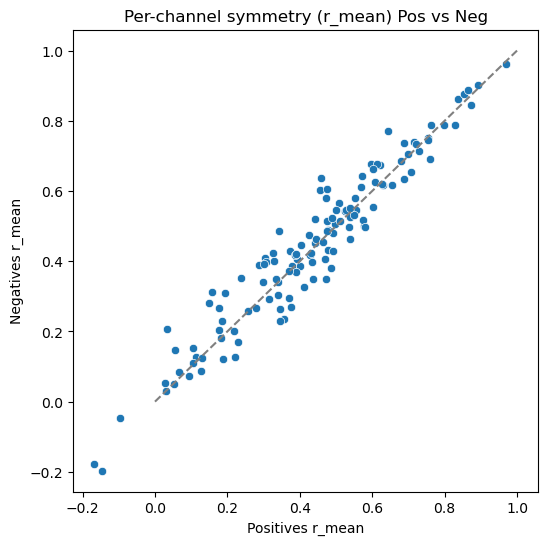

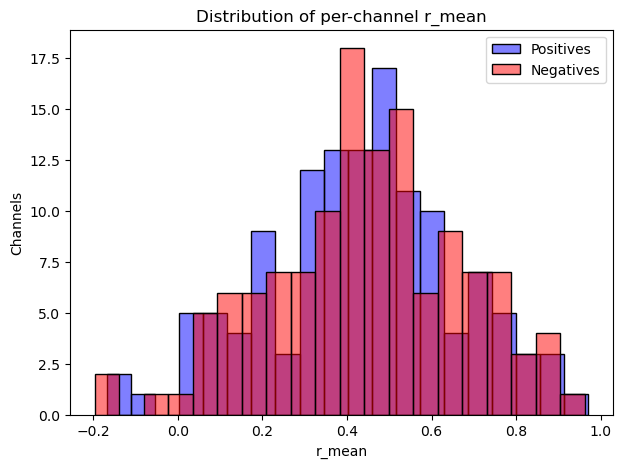

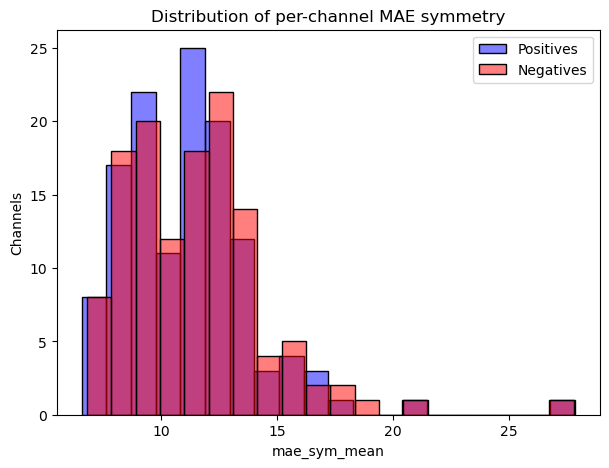

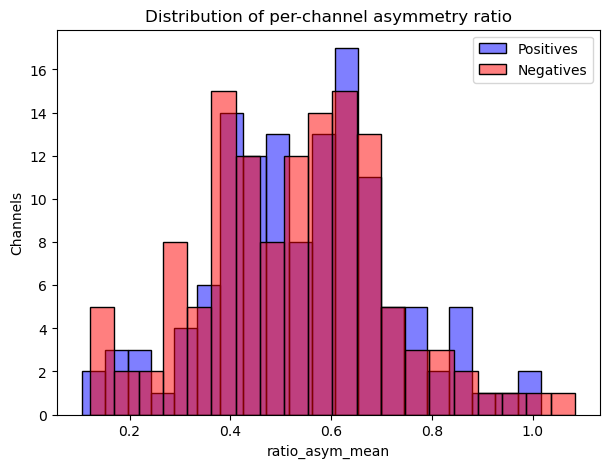

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# === CONFIG ===
POS_FOLDER = "z_symmetry_results_nb/"
NEG_FOLDER = "z_symmetry_results_negatives/"
POS_CSV = "aggregate_by_channel_across_pairs.csv"
NEG_CSV = "aggregate_by_channel_across_pairs_neg.csv"
OUTDIR = Path("pos_vs_neg_channel_comparison")
OUTDIR.mkdir(parents=True, exist_ok=True)
# ==============

# Load data
pos = pd.read_csv(POS_FOLDER + POS_CSV)
neg = pd.read_csv(NEG_FOLDER + NEG_CSV)

# Add suffixes and merge
pos = pos.rename(columns={c: f"{c}_pos" for c in pos.columns if c != "channel"})
neg = neg.rename(columns={c: f"{c}_neg" for c in neg.columns if c != "channel"})
df = pos.merge(neg, on="channel", how="inner")

# Compute differences
df["r_diff"] = df["r_mean_pos"] - df["r_mean_neg"]
df["mae_diff"] = df["mae_sym_mean_pos"] - df["mae_sym_mean_neg"]
df["ratio_asym_diff"] = df["ratio_asym_mean_pos"] - df["ratio_asym_mean_neg"]

# Save comparison table
df.to_csv(OUTDIR / "channel_comparison_table.csv", index=False)

# Rank by r_mean difference
ranked = df.sort_values("r_diff", ascending=False)
display(ranked.head(15))
display(ranked.tail(15))

# --- Plots ---

# 1. Scatter of r_mean (pos vs neg)
plt.figure(figsize=(6,6))
sns.scatterplot(data=df, x="r_mean_pos", y="r_mean_neg")
plt.plot([0,1],[0,1],"--",color="grey")
plt.xlabel("Positives r_mean")
plt.ylabel("Negatives r_mean")
plt.title("Per-channel symmetry (r_mean) Pos vs Neg")
plt.savefig(OUTDIR/"scatter_rmean_pos_vs_neg.png", dpi=200, bbox_inches="tight")
plt.show()

# 2. Histogram of r_mean distributions
plt.figure(figsize=(7,5))
sns.histplot(df["r_mean_pos"], color="blue", label="Positives", alpha=0.5, bins=20)
sns.histplot(df["r_mean_neg"], color="red", label="Negatives", alpha=0.5, bins=20)
plt.xlabel("r_mean")
plt.ylabel("Channels")
plt.title("Distribution of per-channel r_mean")
plt.legend()
plt.savefig(OUTDIR/"hist_rmean_distribution.png", dpi=200, bbox_inches="tight")
plt.show()

# 3. Histogram of mae_sym_mean distributions
plt.figure(figsize=(7,5))
sns.histplot(df["mae_sym_mean_pos"], color="blue", label="Positives", alpha=0.5, bins=20)
sns.histplot(df["mae_sym_mean_neg"], color="red", label="Negatives", alpha=0.5, bins=20)
plt.xlabel("mae_sym_mean")
plt.ylabel("Channels")
plt.title("Distribution of per-channel MAE symmetry")
plt.legend()
plt.savefig(OUTDIR/"hist_mae_distribution.png", dpi=200, bbox_inches="tight")
plt.show()

# 4. Histogram of ratio_asym_mean distributions
plt.figure(figsize=(7,5))
sns.histplot(df["ratio_asym_mean_pos"], color="blue", label="Positives", alpha=0.5, bins=20)
sns.histplot(df["ratio_asym_mean_neg"], color="red", label="Negatives", alpha=0.5, bins=20)
plt.xlabel("ratio_asym_mean")
plt.ylabel("Channels")
plt.title("Distribution of per-channel asymmetry ratio")
plt.legend()
plt.savefig(OUTDIR/"hist_ratioasym_distribution.png", dpi=200, bbox_inches="tight")
plt.show()


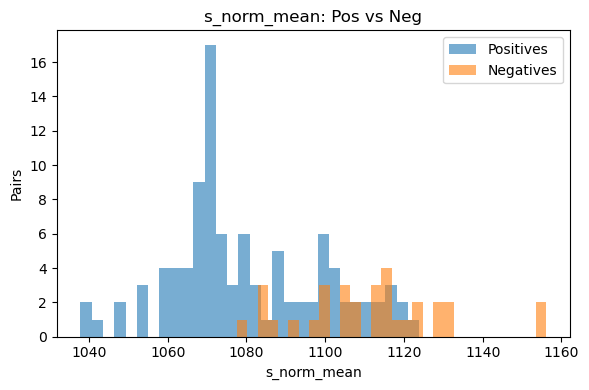

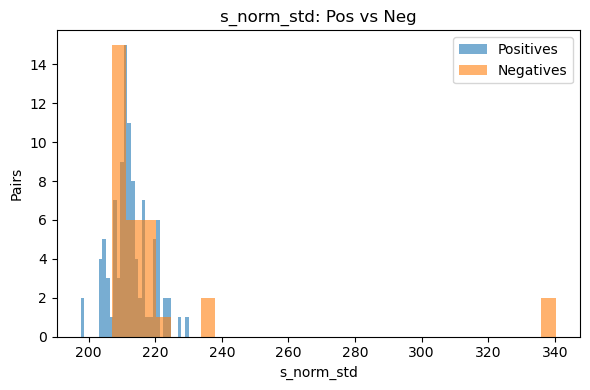

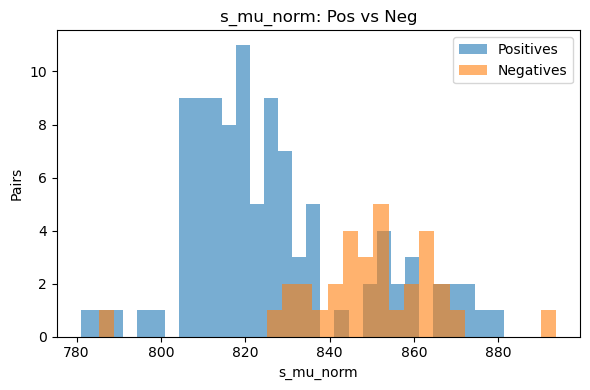

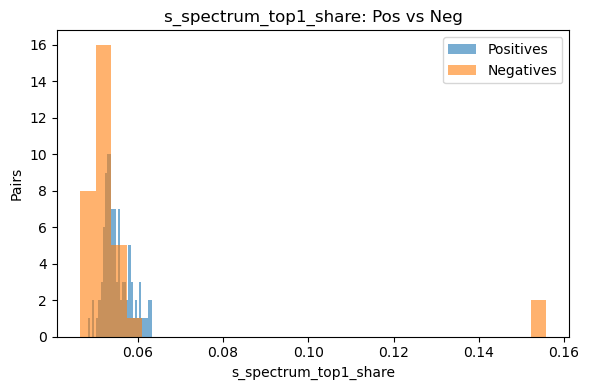

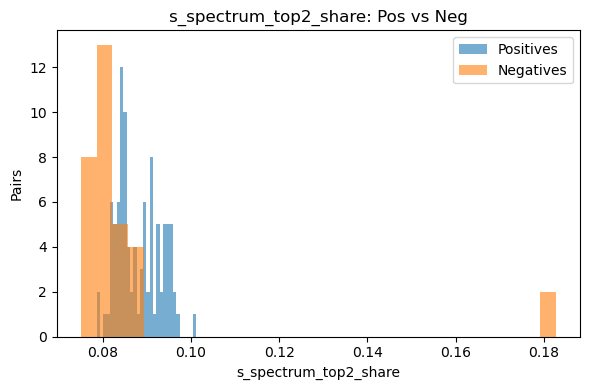

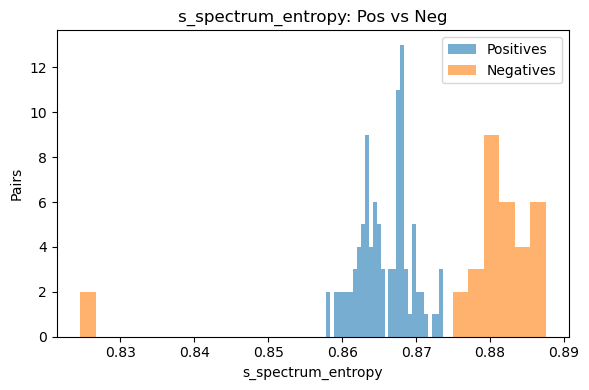

Saved: s_features_compare


In [12]:
# === S features: discriminative summaries for pos vs neg ===
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

# ----- CONFIG -----
POS_ROOT = Path("/home/natasha/multimodal_model/outputs/boltz_runs/positives")
NEG_ROOT = Path("/home/natasha/multimodal_model/outputs/boltz_runs/negatives")
N_POS, N_NEG = 100, 100     # adjust if needed
OUTDIR = Path("s_features_compare"); OUTDIR.mkdir(parents=True, exist_ok=True)
# -------------------

def iter_npz(root: Path, n: int):
    for i in range(n):
        pid = f"pair_{i:03d}"
        p = root/pid/f"boltz_results_{pid}"/"predictions"/pid/f"embeddings_{pid}.npz"
        if p.exists(): yield pid, p

def s_features(s: np.ndarray) -> dict:
    if s.ndim == 3: s = s[0]                  # (L,D)
    L, D = s.shape
    norms = np.linalg.norm(s, axis=1)
    mu = s.mean(axis=0)
    X = s - mu
    # thin SVD for spectrum without sklearn
    sv = np.linalg.svd(X, full_matrices=False, compute_uv=False)
    sv2, ssum = sv**2, float((sv**2).sum() + 1e-12)
    p = sv2 / ssum
    p = p[p>0]
    ent = float(-(p*np.log(p)).sum() / (np.log(len(p)) if len(p)>1 else 1.0))
    return dict(
        L=L, D=D,
        s_norm_mean=float(norms.mean()),
        s_norm_std=float(norms.std()),
        s_mu_norm=float(np.linalg.norm(mu)),
        s_spectrum_top1_share=float(sv2[0]/ssum) if sv2.size else np.nan,
        s_spectrum_top2_share=float(sv2[:2].sum()/ssum) if sv2.size>=2 else np.nan,
        s_spectrum_entropy=ent
    )

def collect(root: Path, n: int, label: str):
    rows=[]
    for pid, npz_path in iter_npz(root, n):
        try:
            data = np.load(npz_path, allow_pickle=True)
            if "s" not in data.files: continue
            feats = s_features(data["s"])
            feats.update(pair=pid, label=label)
            rows.append(feats)
        except Exception as e:
            print(f"[WARN] {label} {pid}: {e}")
    return pd.DataFrame(rows)

pos_df = collect(POS_ROOT, N_POS, "pos")
neg_df = collect(NEG_ROOT, N_NEG, "neg")
s_all = pd.concat([pos_df, neg_df], ignore_index=True)
s_all.to_csv(OUTDIR/"s_features_per_pair.csv", index=False)

summary = (s_all.groupby("label")
           .agg({c:["mean","std","count"] for c in s_all.columns if c not in ["pair","label"]}))
summary.to_csv(OUTDIR/"s_features_summary_by_label.csv")

def hist(col, bins=30):
    plt.figure(figsize=(6,4))
    a = s_all.query("label=='pos'")[col].dropna()
    b = s_all.query("label=='neg'")[col].dropna()
    plt.hist(a, bins=bins, alpha=0.6, label="Positives")
    plt.hist(b, bins=bins, alpha=0.6, label="Negatives")
    plt.xlabel(col); plt.ylabel("Pairs"); plt.title(f"{col}: Pos vs Neg"); plt.legend()
    plt.tight_layout(); plt.savefig(OUTDIR/f"hist_{col}.png", dpi=200); plt.show()

for col in ["s_norm_mean","s_norm_std","s_mu_norm","s_spectrum_top1_share","s_spectrum_top2_share","s_spectrum_entropy"]:
    hist(col)

print("Saved:", OUTDIR)


##### Z Features

In [13]:
# === Z-derived features: pos vs neg ===
from pathlib import Path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

POS_ROOT = Path("/home/natasha/multimodal_model/outputs/boltz_runs/positives")
NEG_ROOT = Path("/home/natasha/multimodal_model/outputs/boltz_runs/negatives")
N_POS, N_NEG = 100, 100
OUTDIR = Path("z_features_compare"); OUTDIR.mkdir(parents=True, exist_ok=True)

def iter_npz(root: Path, n: int):
    for i in range(n):
        pid = f"pair_{i:03d}"
        p = root/pid/f"boltz_results_{pid}"/"predictions"/pid/f"embeddings_{pid}.npz"
        if p.exists(): yield pid, p

def symmetry_metrics(Z):
    # Z: (L,L,C)
    L,_,C = Z.shape
    iu = np.triu_indices(L,1)
    r_list, mae_list, ratio_asym_list = [], [], []
    diag_means, offdiag_means = [], []
    for c in range(C):
        M = Z[...,c]
        up, lo = M[iu], M[(iu[1], iu[0])]
        mae_list.append(np.abs(up-lo).mean())
        if up.std()>0 and lo.std()>0:
            r_list.append(np.corrcoef(up, lo)[0,1])
        else:
            r_list.append(np.nan)
        S = 0.5*(M+M.T); A = 0.5*(M-M.T)
        ratio_asym_list.append(float(np.linalg.norm(A)/(np.linalg.norm(S)+1e-12)))
        diag_means.append(float(np.diag(M).mean()))
        offdiag_means.append(float(up.mean()))
    return dict(
        overall_r=np.nanmean(r_list),
        overall_mae_sym=float(np.mean(mae_list)),
        ratio_asym_mean=float(np.mean(ratio_asym_list)),
        diag_mean_mean=float(np.mean(diag_means)),
        offdiag_mean_mean=float(np.mean(offdiag_means))
    )

def z_features(Z):
    # average symmetric part across channels, eigen concentration
    L,_,C = Z.shape
    S_avg = np.mean([(Z[...,c]+Z[...,c].T)*0.5 for c in range(C)], axis=0)
    # eigvalsh for symmetric matrix
    ev = np.linalg.eigvalsh(S_avg)
    ev_abs = np.sort(np.abs(ev))[::-1]
    tot = float(ev_abs.sum()+1e-12)
    return dict(
        z_eig_top1_share=float(ev_abs[0]/tot),
        z_eig_top2_share=float(ev_abs[:2].sum()/tot),
        z_trace=float(np.trace(S_avg)),
        L=L, C=C
    )

def collect(root: Path, n: int, label: str):
    rows=[]
    for pid, p in iter_npz(root, n):
        try:
            data = np.load(p, allow_pickle=True)
            if "z" not in data.files: continue
            Z = data["z"][0] if data["z"].ndim==4 else data["z"]   # (L,L,C)
            feats = {}
            feats.update(symmetry_metrics(Z))
            feats.update(z_features(Z))
            feats.update(pair=pid, label=label)
            rows.append(feats)
        except Exception as e:
            print(f"[WARN] {label} {pid}: {e}")
    return pd.DataFrame(rows)

pos = collect(POS_ROOT, N_POS, "pos")
neg = collect(NEG_ROOT, N_NEG, "neg")
z_all = pd.concat([pos, neg], ignore_index=True)
z_all.to_csv(OUTDIR/"z_features_per_pair.csv", index=False)

def hist(col, bins=30):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6,4))
    a = z_all.query("label=='pos'")[col].dropna()
    b = z_all.query("label=='neg'")[col].dropna()
    plt.hist(a, bins=bins, alpha=0.6, label="Positives")
    plt.hist(b, bins=bins, alpha=0.6, label="Negatives")
    plt.xlabel(col); plt.ylabel("Pairs"); plt.title(f"{col}: Pos vs Neg"); plt.legend()
    plt.tight_layout(); plt.savefig(OUTDIR/f"hist_{col}.png", dpi=200); plt.show()

for col in ["overall_r","overall_mae_sym","ratio_asym_mean","diag_mean_mean","offdiag_mean_mean","z_eig_top1_share","z_eig_top2_share","z_trace"]:
    hist(col)

print("Saved:", OUTDIR)


KeyboardInterrupt: 

#### Investigating Different Transformations to Z 
- Symmetrisation + adding identity
- Randomising Z
- Normalisation by channel (whether to do or not)

In [14]:
import numpy as np

def symmetrise_Z(Z):
    """
    Z: (L, L, C)
    Return a version where each channel is symmetrised: 0.5*(M + M.T).
    This intentionally **removes** antisymmetric information.
    """
    L, _, C = Z.shape
    Z_sym = np.empty_like(Z, dtype=float)
    for c in range(C):
        M = Z[..., c]
        Z_sym[..., c] = 0.5 * (M + M.T)
    return Z_sym


def randomise_Z(Z, mode="shuffle"):
    """
    Break the structure of Z while roughly preserving low-level statistics.
    - mode="shuffle": shuffle entries within each channel.
    """
    L, _, C = Z.shape
    Z_rand = np.empty_like(Z, dtype=float)
    for c in range(C):
        M = Z[..., c]
        flat = M.reshape(-1)
        np.random.shuffle(flat)       # in-place permutation
        Z_rand[..., c] = flat.reshape(L, L)
    return Z_rand


def normalise_Z_channels(Z, eps=1e-8):
    """
    Per-channel standardisation: (M - mean)/std.
    This removes scale/offset differences per channel.
    """
    L, _, C = Z.shape
    Z_norm = np.empty_like(Z, dtype=float)
    for c in range(C):
        M = Z[..., c]
        mu = M.mean()
        sigma = M.std()
        Z_norm[..., c] = (M - mu) / (sigma + eps)
    return Z_norm


In [8]:
def collect(root: Path, n: int, label: str, transform=None, transform_name="raw"):
    rows = []
    for pid, p in iter_npz(root, n):
        try:
            data = np.load(p, allow_pickle=True)
            if "z" not in data.files:
                continue
            Z = data["z"][0] if data["z"].ndim == 4 else data["z"]  # (L,L,C)

            if transform is not None:
                Z = transform(Z)

            feats = {}
            feats.update(symmetry_metrics(Z))
            feats.update(z_features(Z))
            feats.update(pair=pid, label=label, transform=transform_name)
            rows.append(feats)
        except Exception as e:
            print(f"[WARN] {label} {pid}: {e}")
    return pd.DataFrame(rows)


In [ ]:
# Baseline (raw Z)
pos_raw = collect(POS_ROOT, N_POS, "pos", transform=None, transform_name="raw")
neg_raw = collect(NEG_ROOT, N_NEG, "neg", transform=None, transform_name="raw")

# Symmetrised
pos_sym = collect(POS_ROOT, N_POS, "pos", transform=symmetrise_Z, transform_name="sym")
neg_sym = collect(NEG_ROOT, N_NEG, "neg", transform=symmetrise_Z, transform_name="sym")

# Randomised
pos_rand = collect(POS_ROOT, N_POS, "pos", transform=randomise_Z, transform_name="rand")
neg_rand = collect(NEG_ROOT, N_NEG, "neg", transform=randomise_Z, transform_name="rand")

# Channel-normalised (on original, unsymmetrised Z)
pos_norm = collect(POS_ROOT, N_POS, "pos", transform=normalise_Z_channels, transform_name="norm")
neg_norm = collect(NEG_ROOT, N_NEG, "neg", transform=normalise_Z_channels, transform_name="norm")

z_all = pd.concat([pos_raw, neg_raw, pos_sym, neg_sym, pos_rand, neg_rand, pos_norm, neg_norm], ignore_index=True)

#z_all.to_csv(OUTDIR / "z_features_per_pair_with_transforms.csv", index=False)

# took 54 mins to do 100 samples on CPU
# maybe use GPU next time for larger group?


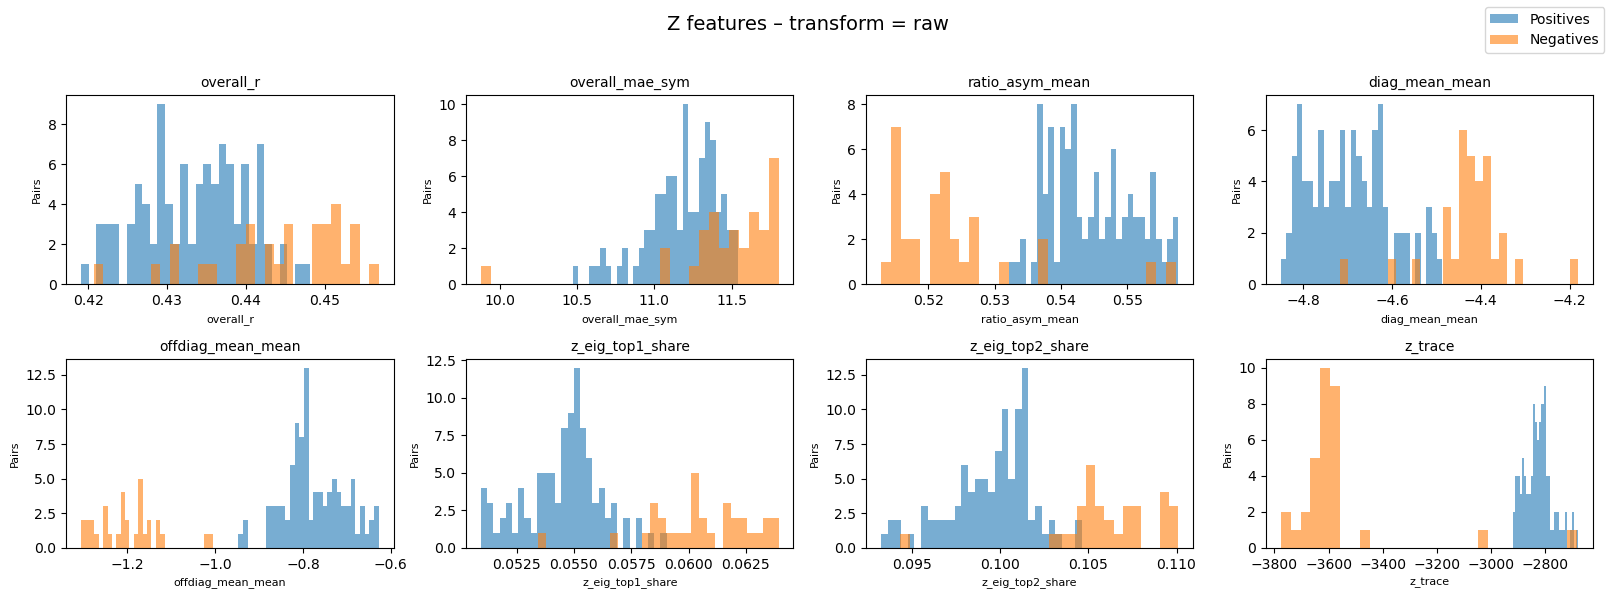

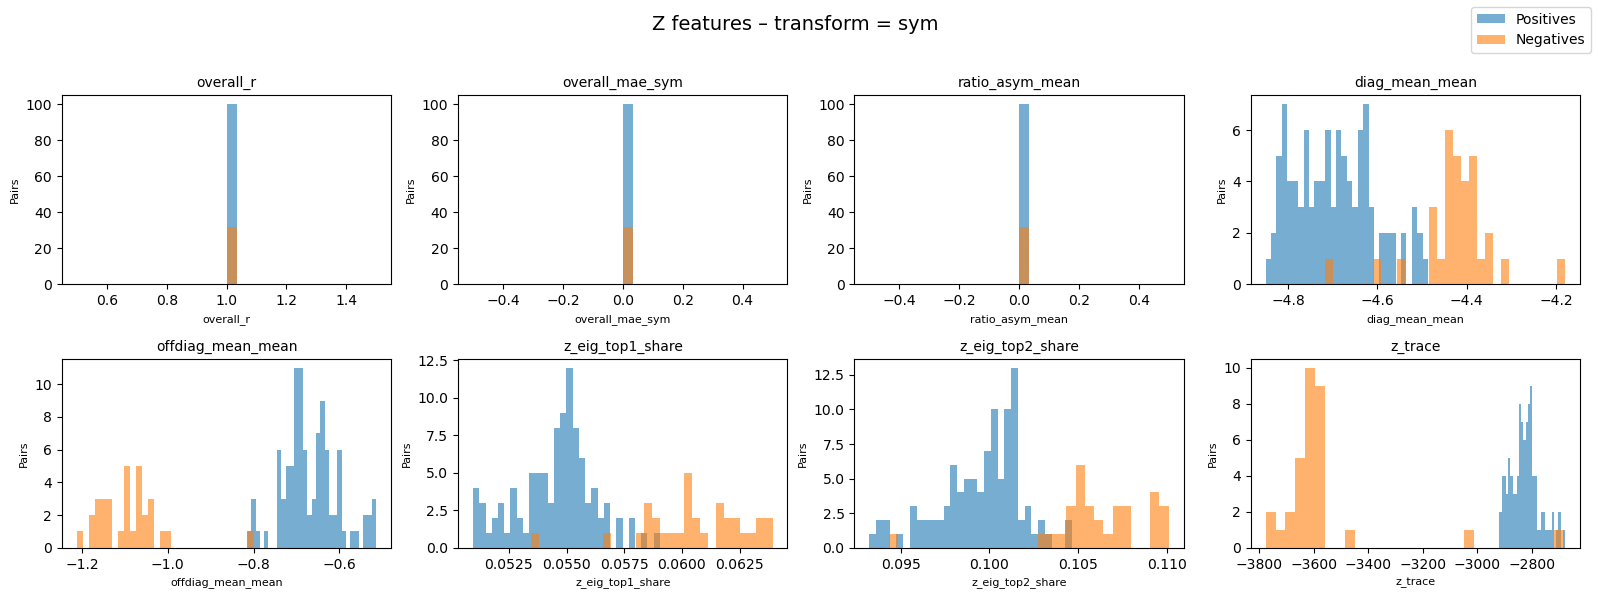

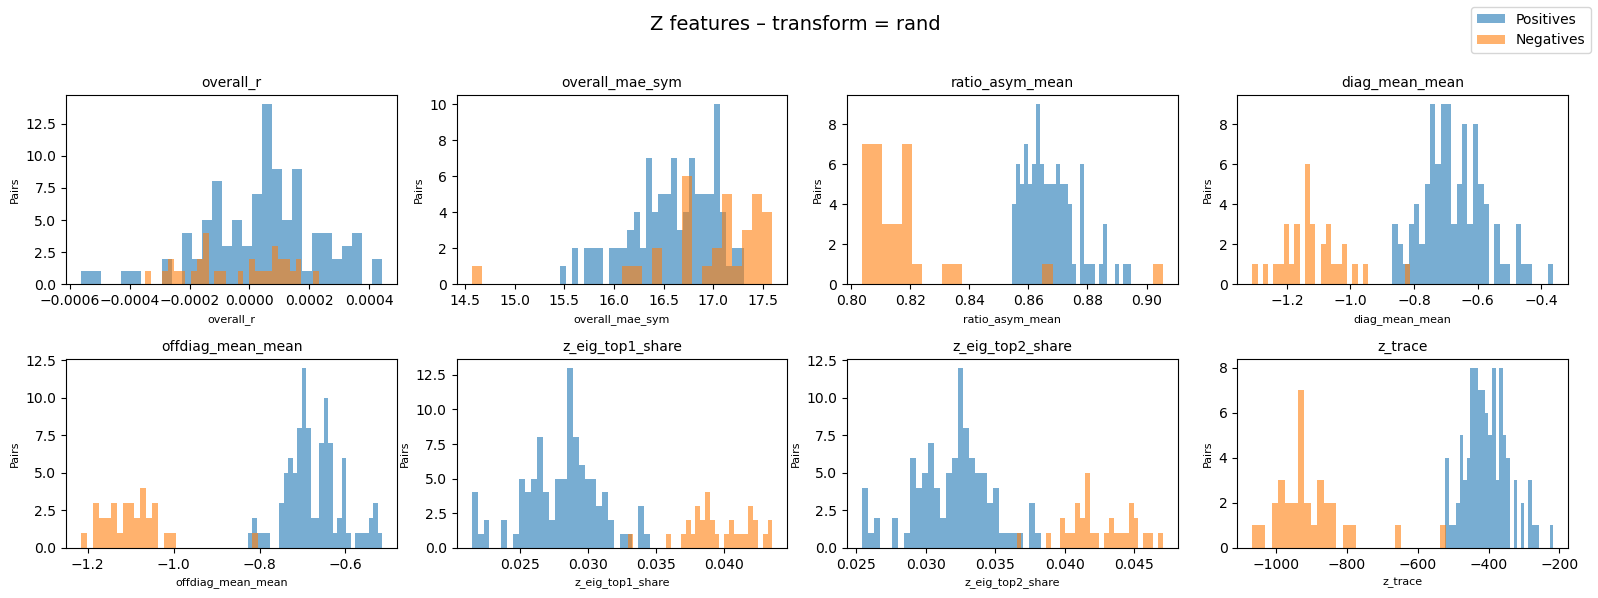

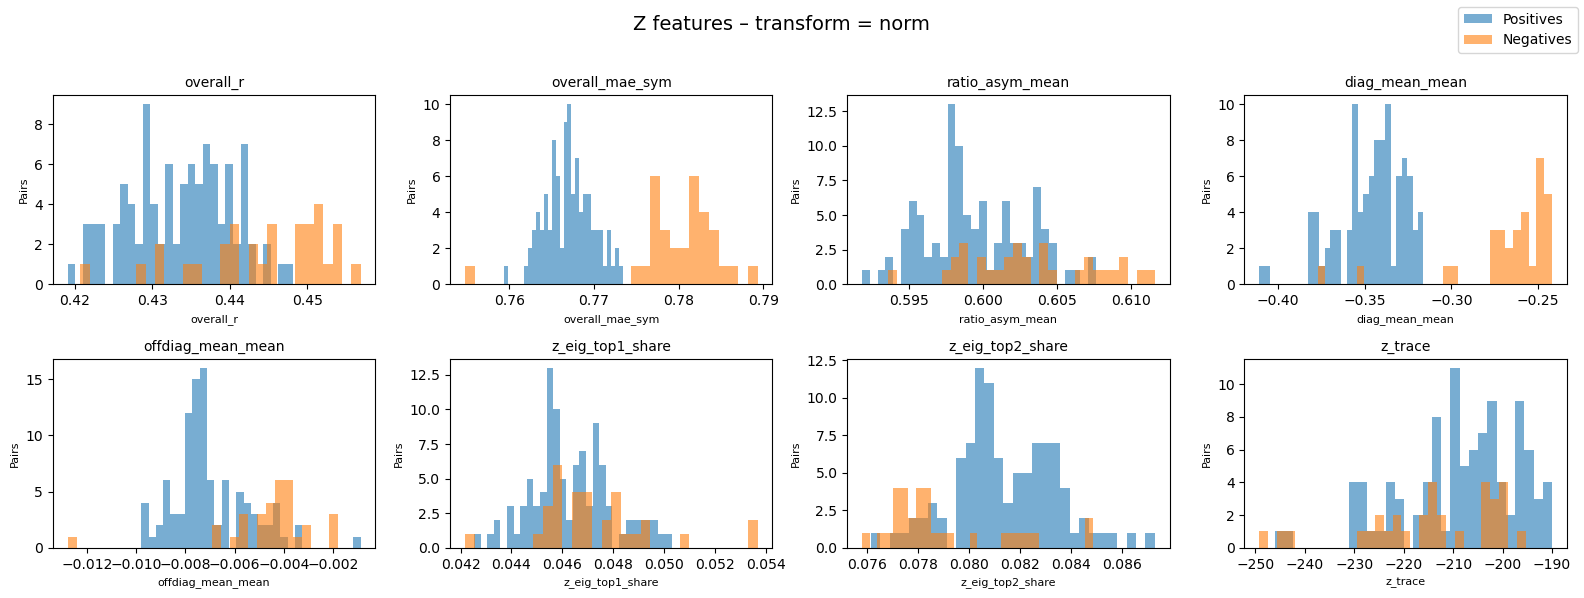

In [12]:
import matplotlib.pyplot as plt

cols = [
    "overall_r",
    "overall_mae_sym",
    "ratio_asym_mean",
    "diag_mean_mean",
    "offdiag_mean_mean",
    "z_eig_top1_share",
    "z_eig_top2_share",
    "z_trace",
]

def plot_transform_grid(transform_name, bins=30):
    """
    For a given transform (e.g. 'raw', 'sym', 'rand', 'norm'),
    make one figure with 8 subplots (2x4), one per feature.
    """
    subset = z_all.query("transform == @transform_name")

    # 2 rows x 4 columns = 8 subplots
    nrows, ncols = 2, 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    axes = axes.ravel()

    for ax, col in zip(axes, cols):
        a = subset.query("label == 'pos'")[col].dropna()
        b = subset.query("label == 'neg'")[col].dropna()

        ax.hist(a, bins=bins, alpha=0.6, label="Positives")
        ax.hist(b, bins=bins, alpha=0.6, label="Negatives")

        ax.set_title(col, fontsize=10)
        ax.set_xlabel(col, fontsize=8)
        ax.set_ylabel("Pairs", fontsize=8)

    # Single legend for the whole figure (use first axes' handles)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    fig.suptitle(f"Z features – transform = {transform_name}", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])  # leave space for suptitle

    fig.savefig(OUTDIR / f"hist_grid_{transform_name}.png", dpi=200, bbox_inches="tight")
    plt.show()


# Call once per transform
for tname in ["raw", "sym", "rand", "norm"]:
    plot_transform_grid(tname)


Split into Respective Parts

In [31]:
import os
import pandas as pd

home = "/home/natasha/multimodal_model"

positive_manifest_path = os.path.join(home, "data", "manifests", "boltz_100_manifest.csv")
negative_manifest_path = os.path.join(home, "data", "negative_manifests", "boltz_100_manifest.csv")

pos_manifest = pd.read_csv(positive_manifest_path)
neg_manifest = pd.read_csv(negative_manifest_path)

# --- add explicit labels ---
pos_manifest["label"] = "pos"
neg_manifest["label"] = "neg"

# --- create a unique ID per sample ---
pos_manifest["pair_uid"] = "pos_" + pos_manifest["pair_id"].astype(str)
neg_manifest["pair_uid"] = "neg_" + neg_manifest["pair_id"].astype(str)

manifest = pd.concat([pos_manifest, neg_manifest], ignore_index=True)

required_len_cols = ["pep_len", "tcra_len", "tcrb_len", "hla_len"]

# --- basic cleaning ---
manifest = manifest.dropna(subset=["pair_uid"] + required_len_cols).copy()
for c in required_len_cols:
    manifest[c] = pd.to_numeric(manifest[c], errors="coerce")

manifest = manifest.dropna(subset=required_len_cols)
manifest[required_len_cols] = manifest[required_len_cols].astype(int)

manifest["total_len"] = (
    manifest["tcra_len"]
    + manifest["tcrb_len"]
    + manifest["pep_len"]
    + manifest["hla_len"]
)

print("Manifest loaded.")
print("Rows:", len(manifest))
print("Unique pair_uids:", manifest["pair_uid"].nunique())
print("total_len summary:\n", manifest["total_len"].describe())
print("\nHead:\n", manifest[["pair_uid", "pair_id", "label", "total_len"]].head())


Manifest loaded.
Rows: 200
Unique pair_uids: 200
total_len summary:
 count    200.000000
mean     702.760000
std      106.999424
min      593.000000
25%      601.750000
50%      623.500000
75%      817.000000
max      831.000000
Name: total_len, dtype: float64

Head:
        pair_uid   pair_id label  total_len
0  pos_pair_000  pair_000   pos        604
1  pos_pair_001  pair_001   pos        598
2  pos_pair_002  pair_002   pos        601
3  pos_pair_003  pair_003   pos        601
4  pos_pair_004  pair_004   pos        603


In [32]:
# Now pair_uid is unique by construction
manifest_uniq = manifest.set_index("pair_uid")

len_lookup = manifest_uniq[required_len_cols].to_dict(orient="index")

print("len_lookup built. Example:")
k = next(iter(len_lookup))
print(k, len_lookup[k])


len_lookup built. Example:
pos_pair_000 {'pep_len': 10, 'tcra_len': 112, 'tcrb_len': 117, 'hla_len': 365}


In [33]:
import numpy as np

def slice_Z_view(Z, La, Lb, Lp, Lh, view: str):
    """
    Z: (L, L, C) for full complex.
    Residue order assumed: [TCRa | TCRb | peptide | MHC]

    Returns a square submatrix Z_view of shape (L_view, L_view, C).
    """
    La, Lb, Lp, Lh = map(int, [La, Lb, Lp, Lh])

    i0 = 0
    i1 = La
    i2 = La + Lb
    i3 = La + Lb + Lp
    i4 = La + Lb + Lp + Lh

    # Safety: ensure Z matches expected full length
    if Z.shape[0] != i4 or Z.shape[1] != i4:
        raise ValueError(f"Z shape {Z.shape[:2]} != expected full length {i4} (La+Lb+Lp+Lh)")

    idx_tcr = np.arange(i0, i2)
    idx_pep = np.arange(i2, i3)
    idx_mhc = np.arange(i3, i4)

    if view == "complex":
        idx = np.arange(i0, i4)
    elif view == "tcr_pep":
        idx = np.concatenate([idx_tcr, idx_pep])
    elif view == "tcr_mhc":
        idx = np.concatenate([idx_tcr, idx_mhc])
    elif view == "tcr":
        idx = idx_tcr
    elif view == "pep":
        idx = idx_pep
    elif view == "mhc":
        idx = idx_mhc
    else:
        raise ValueError(f"Unknown view: {view}")

    # fancy indexing to keep square
    return Z[np.ix_(idx, idx, np.arange(Z.shape[2]))]


In [34]:
def collect(root: Path, n: int, label: str, len_lookup: dict, view: str,
            transform=None, transform_name="raw"):
   
    rows = []

    prefix = "pos_" if label == "pos" else "neg_"

    for pid, p in iter_npz(root, n):
        pid = str(pid)
        pair_uid = prefix + pid

        lens = len_lookup.get(pair_uid)
        if lens is None:
            print(f"[MISS] {label} {pair_uid}: not in len_lookup")
            continue


        try:
            data = np.load(p, allow_pickle=True)
            if "z" not in data.files:
                continue

            Z = data["z"][0] if data["z"].ndim == 4 else data["z"]  # (L,L,C)

            # Slice into requested view
            La = lens["tcra_len"]
            Lb = lens["tcrb_len"]
            Lp = lens["pep_len"]
            Lh = lens["hla_len"]
            Z = slice_Z_view(Z, La, Lb, Lp, Lh, view=view)

            # Optional transforms (leave as None for "raw")
            if transform is not None:
                Z = transform(Z)

            feats = {}
            feats.update(symmetry_metrics(Z))
            feats.update(z_features(Z))
            feats.update(pair=pid, label=label, transform=transform_name, view=view)
            rows.append(feats)

        except Exception as e:
            print(f"[WARN] {label} {pid} view={view}: {e}")

    return pd.DataFrame(rows)


In [35]:
import numpy as np

def check_Z_matches_manifest(root, n, label, manifest_uniq):
    prefix = "pos_" if label == "pos" else "neg_"

    for pid, p in iter_npz(root, n):
        pair_uid = prefix + str(pid)

        if pair_uid not in manifest_uniq.index:
            print(f"[MISS] {pair_uid}")
            continue

        row = manifest_uniq.loc[pair_uid]
        expected_L = int(row["total_len"])

        data = np.load(p, allow_pickle=True)
        Z = data["z"][0] if data["z"].ndim == 4 else data["z"]
        Lz = Z.shape[0]

        print(f"{pair_uid}: expected={expected_L} | Z={Lz}")

check_Z_matches_manifest(POS_ROOT, 5, "pos", manifest_uniq)
check_Z_matches_manifest(NEG_ROOT, 5, "neg", manifest_uniq)


pos_pair_000: expected=604 | Z=604
pos_pair_001: expected=598 | Z=598
pos_pair_002: expected=601 | Z=601
pos_pair_003: expected=601 | Z=601
pos_pair_004: expected=603 | Z=603
neg_pair_002: expected=812 | Z=812
neg_pair_004: expected=819 | Z=819


In [36]:
VIEWS = ["complex", "tcr_pep", "tcr_mhc", "tcr", "pep", "mhc"]

dfs = []
for view in VIEWS:
    pos = collect(POS_ROOT, N_POS, "pos", len_lookup=len_lookup, view=view, transform=None, transform_name="raw")
    neg = collect(NEG_ROOT, N_NEG, "neg", len_lookup=len_lookup, view=view, transform=None, transform_name="raw")
    dfs.append(pos)
    dfs.append(neg)

z_all = pd.concat(dfs, ignore_index=True)

# Optional: save
# z_all.to_csv(OUTDIR / "z_features_raw_by_view.csv", index=False)

print(z_all.groupby(["view", "label"]).size())


view     label
complex  neg       32
         pos      100
mhc      neg       32
         pos      100
pep      neg       32
         pos      100
tcr      neg       32
         pos      100
tcr_mhc  neg       32
         pos      100
tcr_pep  neg       32
         pos      100
dtype: int64


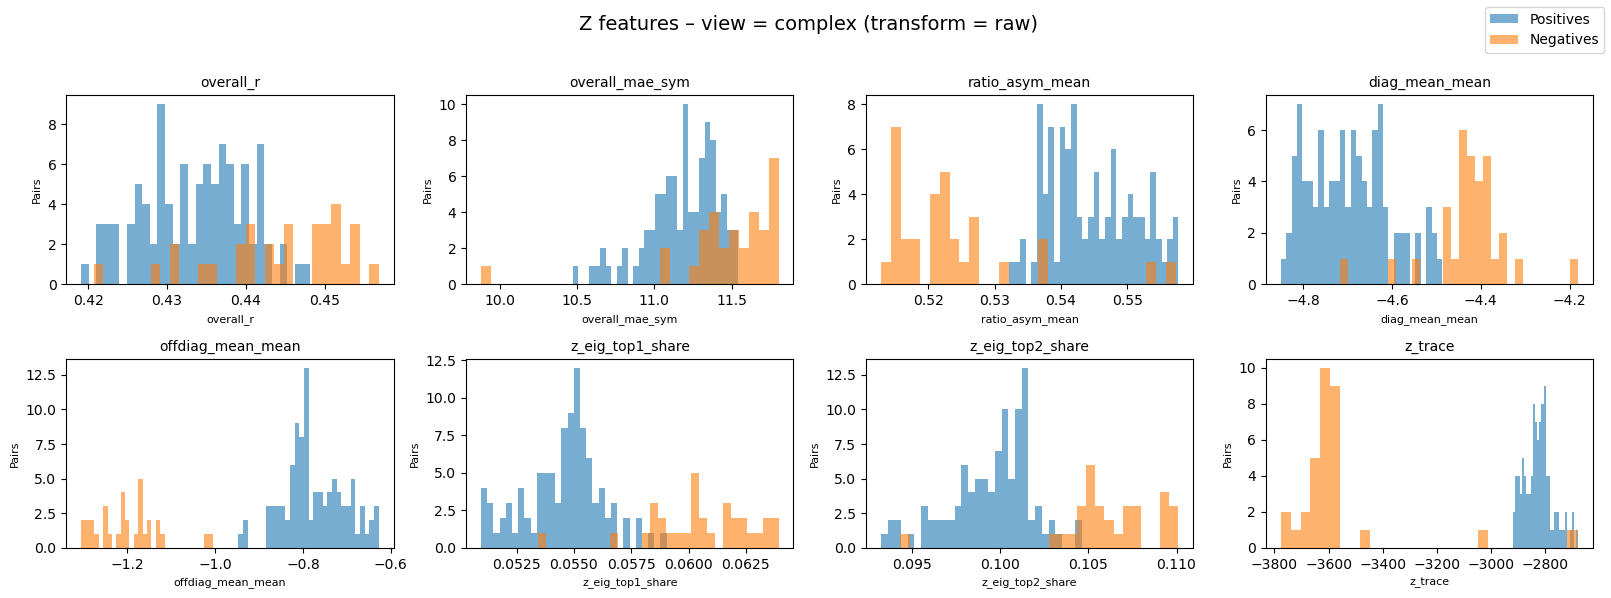

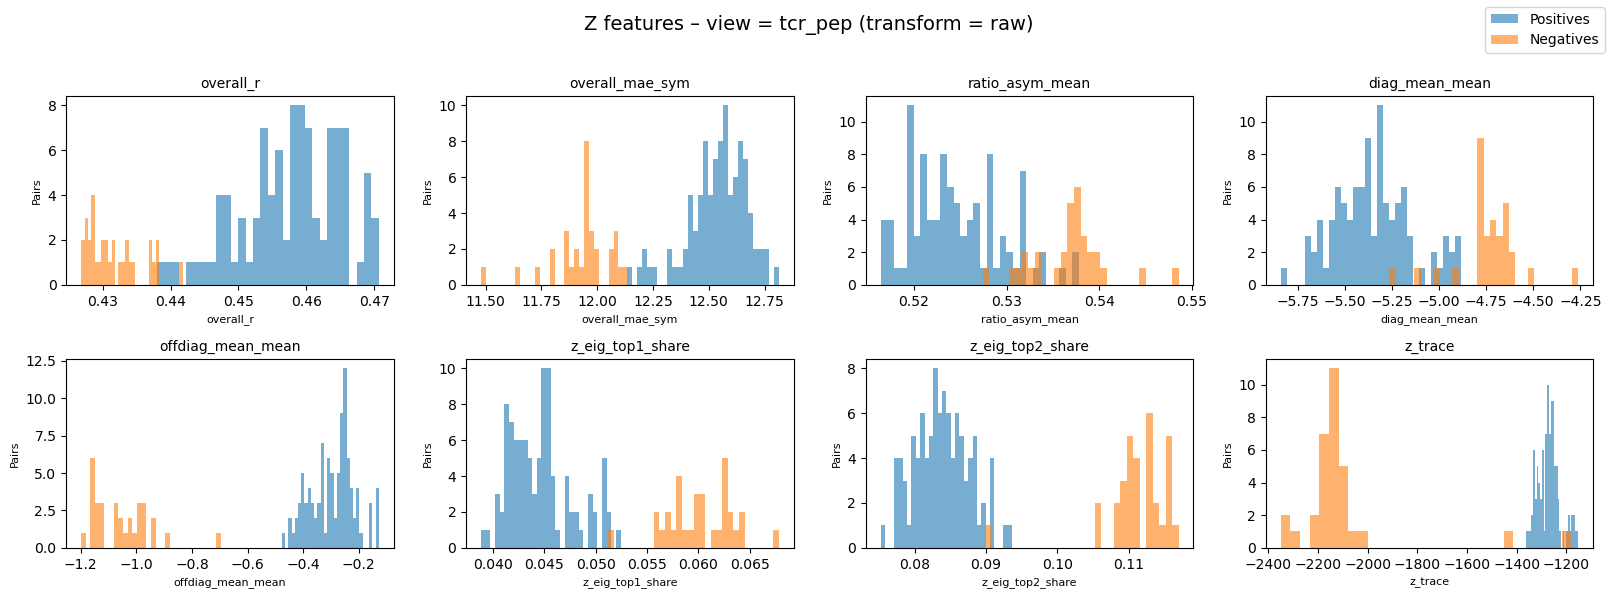

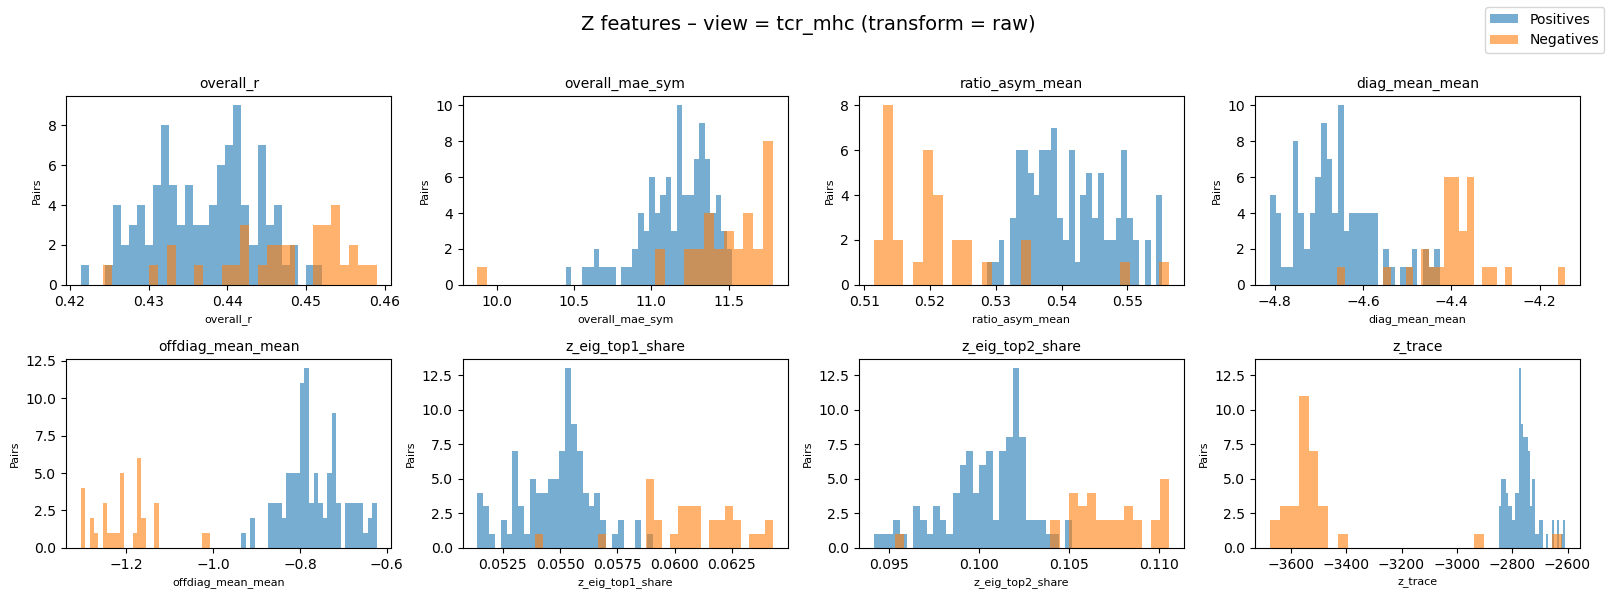

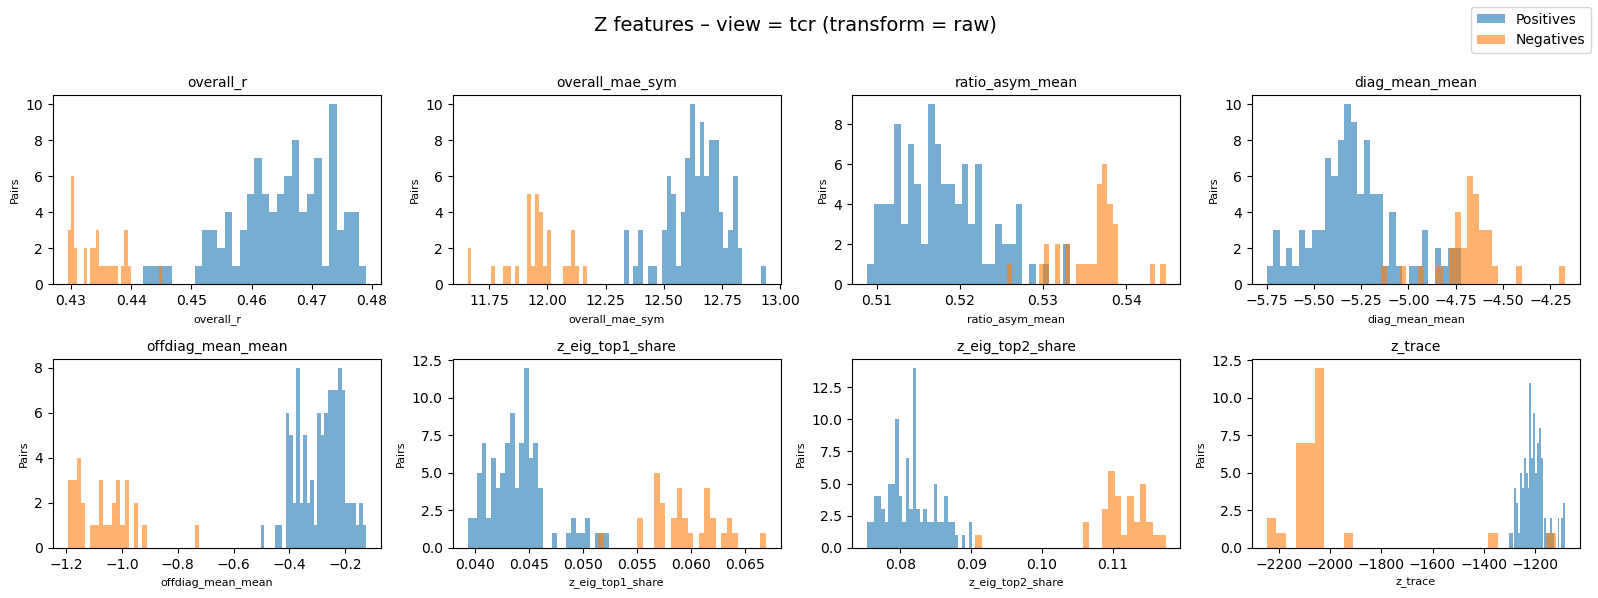

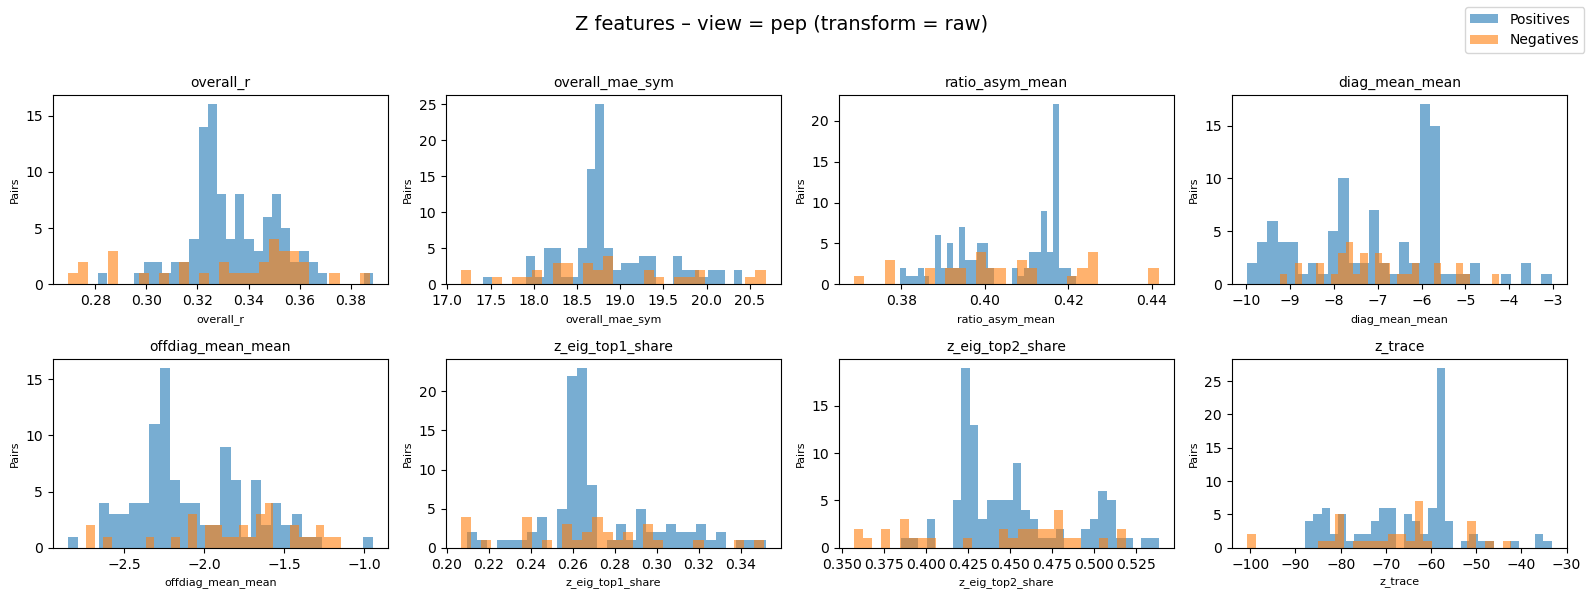

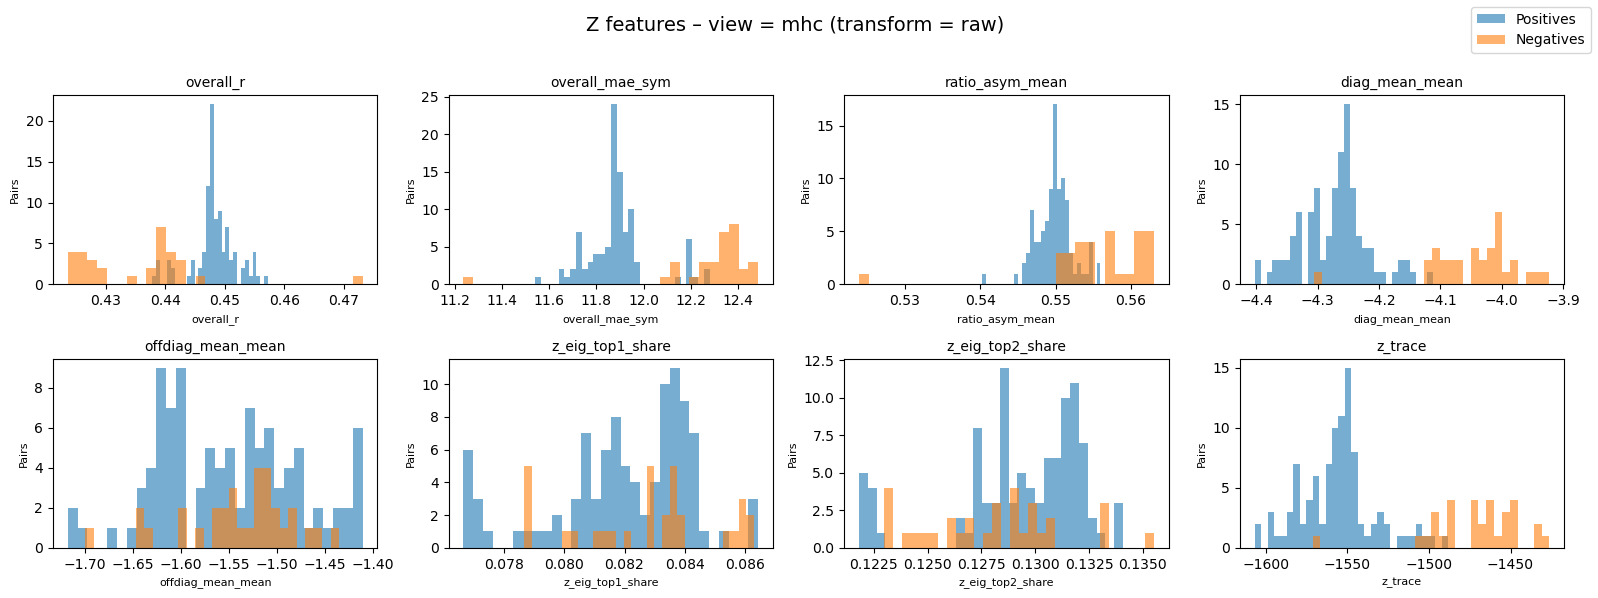

In [37]:
import matplotlib.pyplot as plt

cols = [
    "overall_r",
    "overall_mae_sym",
    "ratio_asym_mean",
    "diag_mean_mean",
    "offdiag_mean_mean",
    "z_eig_top1_share",
    "z_eig_top2_share",
    "z_trace",
]

def plot_view_grid(view_name, transform_name="raw", bins=30):
    subset = z_all.query("view == @view_name and transform == @transform_name")

    nrows, ncols = 2, 4
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 3*nrows))
    axes = axes.ravel()

    for ax, col in zip(axes, cols):
        a = subset.query("label == 'pos'")[col].dropna()
        b = subset.query("label == 'neg'")[col].dropna()

        ax.hist(a, bins=bins, alpha=0.6, label="Positives")
        ax.hist(b, bins=bins, alpha=0.6, label="Negatives")

        ax.set_title(col, fontsize=10)
        ax.set_xlabel(col, fontsize=8)
        ax.set_ylabel("Pairs", fontsize=8)

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    fig.suptitle(f"Z features – view = {view_name} (transform = {transform_name})", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.96])

    fig.savefig(OUTDIR / f"hist_grid_view_{view_name}_{transform_name}.png", dpi=200, bbox_inches="tight")
    plt.show()

for v in VIEWS:
    plot_view_grid(v, transform_name="raw")


#### Biological Signals for Z

In [ ]:
# # Loader for saved z

# import numpy as np, pickle
# from pathlib import Path

# def load_first_z(run_dir: Path):
#     # 1) .npz with 'z'
#     for p in run_dir.rglob("*.npz"):
#         try:
#             d = np.load(p, allow_pickle=True)
#             if "z" in d.files:
#                 return d["z"], str(p)
#         except Exception:
#             pass
#     # 2) .pt with 'z'
#     for p in run_dir.rglob("*.pt"):
#         try:
#             import torch
#             obj = torch.load(p, map_location="cpu")
#             if isinstance(obj, dict) and "z" in obj:
#                 z = obj["z"]
#                 if hasattr(z, "detach"):
#                     z = z.detach().cpu().numpy()
#                 else:
#                     z = np.array(z)
#                 return z, str(p)
#         except Exception:
#             pass
#     # 3) .pkl with 'z'
#     for p in run_dir.rglob("*.pkl"):
#         try:
#             with open(p, "rb") as f:
#                 obj = pickle.load(f)
#             if isinstance(obj, dict) and "z" in obj:
#                 return np.array(obj["z"]), str(p)
#         except Exception:
#             pass
#     return None, None

# # Quick check for the test pair
# z, z_path = load_first_z(run_dir)
# print("z path:", z_path, "| shape:", None if z is None else z.shape)


z path: /home/natasha/multimodal_model/outputs/boltz_runs/pair_000/boltz_results_pair_000/predictions/pair_000/embeddings_pair_000.npz | shape: (1, 720, 720, 128)


In [ ]:
# Interface slice & peptide properties utils

import numpy as np, re, pandas as pd

# def cross_interface_summary(z: np.ndarray, la:int, lb:int, lc:int, ld:int, le:int):
#     assert z is not None, "z not loaded"
#     # reduce feature dim if 3D
#     z2d = z.mean(axis=2) if z.ndim == 3 else z
#     L = la + lb + lc + ld + le
#     assert z2d.shape[0] >= L and z2d.shape[1] >= L, f"z shape {z2d.shape} incompatible with lengths"
#     a0,a1 = 0, la
#     b0,b1 = a1, a1+lb
#     c0,c1 = b1, b1+lc
#     iface = z2d[a0:b1, c0:c1]
#     stats = {
#         "z_iface_mean": float(np.nanmean(iface)),
#         "z_iface_absmean": float(np.nanmean(np.abs(iface))),
#         "z_iface_min": float(np.nanmin(iface)),
#         "z_iface_max": float(np.nanmax(iface)),
#         "z_iface_sum": float(np.nansum(iface)),
#         "z_iface_l2":  float(np.linalg.norm(iface)),
#     }
#     return stats, iface


def cross_interface_summary(z: np.ndarray, la:int, lb:int, lc:int, ld:int, le:int):
    assert z is not None, "z not loaded"
    # reduce feature dim if 3D or 4D
    if z.ndim == 4:
        # Handle 4D tensor: (batch, seq1, seq2, features) -> (seq1, seq2)
        z2d = z.mean(axis=(0, 3))  # Average over batch and feature dimensions
    elif z.ndim == 3:
        # Handle 3D tensor: (seq1, seq2, features) -> (seq1, seq2)
        z2d = z.mean(axis=2)
    else:
        # Handle 2D tensor: (seq1, seq2) -> (seq1, seq2)
        z2d = z
    
    L = la + lb + lc + ld + le
    assert z2d.shape[0] >= L and z2d.shape[1] >= L, f"z shape {z2d.shape} incompatible with lengths"
    a0,a1 = 0, la
    b0,b1 = a1, a1+lb
    c0,c1 = b1, b1+lc
    iface = z2d[a0:b1, c0:c1]
    stats = {
        "z_iface_mean": float(np.nanmean(iface)),
        "z_iface_absmean": float(np.nanmean(np.abs(iface))),
        "z_iface_min": float(np.nanmin(iface)),
        "z_iface_max": float(np.nanmax(iface)),
        "z_iface_sum": float(np.nansum(iface)),
        "z_iface_l2":  float(np.linalg.norm(iface)),
    }
    return stats, iface

def kyte_doolittle(seq: str):
    scale = {'I':4.5,'V':4.2,'L':3.8,'F':2.8,'C':2.5,'M':1.9,'A':1.8,'G':-0.4,'T':-0.7,'S':-0.8,'W':-0.9,'Y':-1.3,'P':-1.6,'H':-3.2,'E':-3.5,'Q':-3.5,'D':-3.5,'N':-3.5,'K':-3.9,'R':-4.5}
    return np.mean([scale.get(a,0.0) for a in seq]) if seq else np.nan

def net_charge(seq: str, ph=7.0):
    pka = {'D':3.9,'E':4.1,'C':8.3,'Y':10.1,'H':6.0,'K':10.5,'R':12.5}
    if not seq: return np.nan
    charge = 0.0
    for aa in seq:
        if aa in ['D','E','C','Y']:
            charge -= 1.0/(1.0 + 10**(pka[aa]-ph))
        elif aa == 'H':
            charge += 1.0/(1.0 + 10**(ph-pka[aa]))
        elif aa in ['K','R']:
            charge += 1.0/(1.0 + 10**(ph-pka[aa]))
    return charge


In [17]:
# Interface stats for the test pair

# Pull lengths for the test pair from manifest
la = int(mani.loc[mani.pair_id==TEST_PAIR, "tcra_len"].iloc[0])
lb = int(mani.loc[mani.pair_id==TEST_PAIR, "tcrb_len"].iloc[0])
lc = int(mani.loc[mani.pair_id==TEST_PAIR, "pep_len"].iloc[0])
ld = int(mani.loc[mani.pair_id==TEST_PAIR, "hla_len"].iloc[0])
le = 0

stats, iface = cross_interface_summary(z, la, lb, lc, ld, le)
print("Interface stats:", stats)

# Pull peptide sequence from YAML
yaml_text = (YAML_DIR / f"{TEST_PAIR}.yaml").read_text()
m = re.search(r"id:\s*C\s*\n\s*sequence:\s*([A-Z]+)", yaml_text)
pep = m.group(1) if m else ""
print("Peptide:", pep, "| len:", len(pep), "| KD:", kyte_doolittle(pep), "| charge:", net_charge(pep))


Interface stats: {'z_iface_mean': -0.26874902844429016, 'z_iface_absmean': 1.765153408050537, 'z_iface_min': -16.018177032470703, 'z_iface_max': 10.197835922241211, 'z_iface_sum': -615.435302734375, 'z_iface_l2': 116.98826599121094}
Peptide: TTDPSFLGRY | len: 10 | KD: -0.6900000000000001 | charge: -3.1622676602393717e-06


In [18]:
# Aggregate stats for all pairs

rows = []
for _, row in mani.iterrows():
    pair_id = row["pair_id"]
    run_dir_i = RUN_ROOT / pair_id
    z_i, z_path = load_first_z(run_dir_i)
    if z_i is None:
        # Skip pairs without z (e.g., failed run)
        continue

    la, lb, lc, ld, le = int(row["tcra_len"]), int(row["tcrb_len"]), int(row["pep_len"]), int(row["hla_len"]), 0
    s, iface = cross_interface_summary(z_i, la, lb, lc, ld, le)
    # peptide seq
    txt = (YAML_DIR / f"{pair_id}.yaml").read_text()
    m = re.search(r"id:\s*C\s*\n\s*sequence:\s*([A-Z]+)", txt)
    pep = m.group(1) if m else ""
    kd  = kyte_doolittle(pep)
    ch  = net_charge(pep)

    rows.append({
        "pair_id": pair_id,
        "z_file": z_path,
        **s,
        "pep_len": int(row["pep_len"]),
        "pep_kd": kd,
        "pep_charge": ch,
    })

summary = pd.DataFrame(rows).sort_values("pair_id")
print("Parsed", len(summary), "pairs with z")
summary.head(10)


Parsed 100 pairs with z


,pair_id,z_file,z_iface_mean,z_iface_absmean,z_iface_min,z_iface_max,z_iface_sum,z_iface_l2,pep_len,pep_kd,pep_charge
0,pair_000,/home/natasha/multimodal_model/outputs/boltz_r...,-0.268749,1.765153,-16.018177,10.197836,-615.435303,116.988266,10,-0.690000,-0.000003
1,pair_001,/home/natasha/multimodal_model/outputs/boltz_r...,0.038333,1.674755,-12.067080,11.383642,77.279015,102.494041,9,0.288889,0.999203
2,pair_002,/home/natasha/multimodal_model/outputs/boltz_r...,-0.273948,1.666035,-14.490086,15.221775,-619.122192,108.283302,10,-0.690000,-0.000003
3,pair_003,/home/natasha/multimodal_model/outputs/boltz_r...,-0.296896,1.677284,-15.693542,15.779363,-670.985168,109.456627,10,-0.690000,-0.000003
4,pair_004,/home/natasha/multimodal_model/outputs/boltz_r...,-0.121090,1.904197,-15.711399,9.311831,-249.565674,118.612877,9,-1.222222,2.998090
5,pair_005,/home/natasha/multimodal_model/outputs/boltz_r...,-0.583165,1.580691,-12.923672,5.907202,-1329.615967,100.062653,10,-0.140000,0.999997
6,pair_006,/home/natasha/multimodal_model/outputs/boltz_r...,-0.534581,1.757244,-12.292688,6.192862,-1218.844360,111.403175,10,-0.310000,0.000478
7,pair_007,/home/natasha/multimodal_model/outputs/boltz_r...,-0.589982,1.602803,-13.172050,5.849527,-1345.159546,101.144218,10,-0.370000,0.999997
8,pair_008,/home/natasha/multimodal_model/outputs/boltz_r...,-0.666016,1.590455,-9.254304,5.684382,-1518.515381,99.919136,10,0.130000,0.999997
9,pair_009,/home/natasha/multimodal_model/outputs/boltz_r...,-0.587624,1.599582,-12.729144,6.035903,-1339.783691,100.507736,10,-0.400000,0.999997


In [23]:
OUT_CSV = RUN_ROOT / "boltz_100_qc_summary.csv"
summary.to_csv(OUT_CSV, index=False)
print("Saved:", OUT_CSV)


Saved: /home/natasha/multimodal_model/outputs/boltz_runs/boltz_100_qc_summary.csv


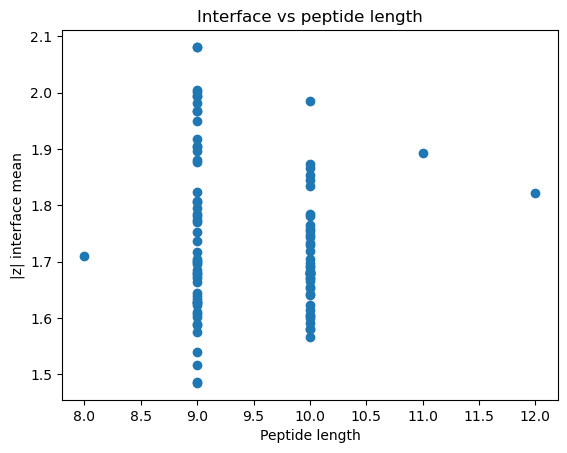

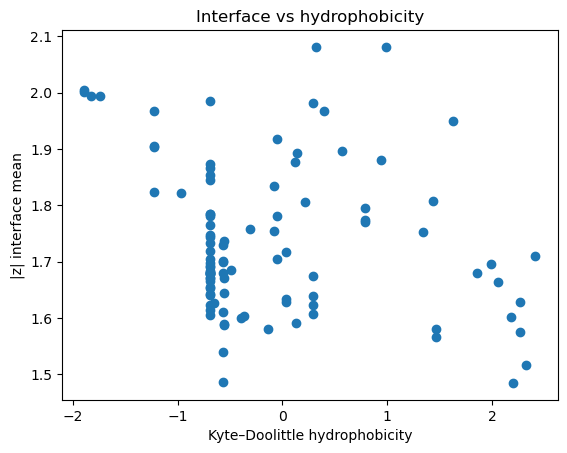

In [20]:
# Quick plots

import matplotlib.pyplot as plt

plt.figure()
plt.scatter(summary["pep_len"], summary["z_iface_absmean"])
plt.xlabel("Peptide length")
plt.ylabel("|z| interface mean")
plt.title("Interface vs peptide length")
plt.show()

plt.figure()
plt.scatter(summary["pep_kd"], summary["z_iface_absmean"])
plt.xlabel("Kyte–Doolittle hydrophobicity")
plt.ylabel("|z| interface mean")
plt.title("Interface vs hydrophobicity")
plt.show()


In [26]:
# Check if z is symmetric
def check_z_symmetry(z):
    print(f"Input tensor shape: {z.shape}")
    
    if z.ndim == 4:
        # For 4D tensor, check symmetry of the middle two dimensions
        print("4D tensor detected - checking symmetry of spatial dimensions")
        z_2d = z[0]  # Remove batch dimension
        print(f"After removing batch dimension: {z_2d.shape}")
        
        # Average over feature dimension to get 2D spatial matrix
        z_2d = z_2d.mean(axis=2)
        print(f"After averaging over features: {z_2d.shape}")
        
        # Check if the 2D matrix is symmetric
        is_symmetric = np.allclose(z_2d, z_2d.T, rtol=1e-5, atol=1e-8)
        print(f"z_2d is symmetric: {is_symmetric}")
        
        # Show some statistics
        diff = np.abs(z_2d - z_2d.T)
        print(f"Max difference between z and z.T: {diff.max()}")
        print(f"Mean difference between z and z.T: {diff.mean()}")
        
        return is_symmetric
        
    elif z.ndim == 3:
        print("3D tensor detected - averaging over feature dimension")
        z_2d = z.mean(axis=2)
        print(f"After averaging over features: {z_2d.shape}")
        return np.allclose(z_2d, z_2d.T)
    else:
        print("2D tensor detected")
        return np.allclose(z, z.T)

# Check symmetry of your loaded z tensor
if 'z' in locals():
    print("=== Checking z tensor symmetry ===")
    is_symmetric = check_z_symmetry(z)
    print(f"\nFinal result: z is symmetric = {is_symmetric}")
else:
    print("z is not loaded. Please load your embeddings file first.")

=== Checking z tensor symmetry ===
Input tensor shape: (1, 720, 720, 128)
4D tensor detected - checking symmetry of spatial dimensions
After removing batch dimension: (720, 720, 128)
After averaging over features: (720, 720)
z_2d is symmetric: False
Max difference between z and z.T: 20.2961368560791
Mean difference between z and z.T: 1.6631077527999878

Final result: z is symmetric = False


In [ ]:
#from gpt 
import numpy as np

def _collapse_to_3d(z, reduce_batch='mean'):
    """
    Ensures shape (L, L, C).
    Accepts z of shape (L, L), (L, L, C), or (B, L, L, C).
    """
    if z.ndim == 2:
        L1, L2 = z.shape
        assert L1 == L2, f"Non-square z: {z.shape}"
        return z[..., None]  # (L,L,1)
    if z.ndim == 3:
        L1, L2, C = z.shape
        assert L1 == L2, f"Non-square z: {z.shape}"
        return z
    if z.ndim == 4:
        B, L1, L2, C = z.shape
        assert L1 == L2, f"Non-square z: {z.shape}"
        if reduce_batch == 'mean':
            return np.nanmean(z, axis=0)   # (L,L,C)
        elif reduce_batch == 'median':
            return np.nanmedian(z, axis=0)
        else:
            raise ValueError("reduce_batch must be 'mean' or 'median'")
    raise ValueError(f"Unsupported z.ndim={z.ndim}")

def global_symmetry_scores(z, reduce_batch='mean'):
    """
    Returns symmetry scores with and without channel averaging.
    """
    Z = _collapse_to_3d(z, reduce_batch=reduce_batch)  # (L,L,C)
    eps = 1e-12

    # Channel-averaged 2D map
    M = np.nanmean(Z, axis=2)  # (L,L)
    s_glob_chanavg = np.linalg.norm(M - M.T) / (np.linalg.norm(M) + eps)

    # 3D Frobenius over channels (treat z as a (L,L,C) tensor)
    s_glob_tensor = np.linalg.norm(Z - np.transpose(Z, (1,0,2))) / (np.linalg.norm(Z) + eps)

    # Also report max/mean abs diff for intuition
    diff2d = np.abs(M - M.T)
    return {
        "s_glob_chanavg": float(s_glob_chanavg),
        "s_glob_tensor": float(s_glob_tensor),
        "max_abs_diff_2d": float(np.nanmax(diff2d)),
        "mean_abs_diff_2d": float(np.nanmean(diff2d)),
        "shape": Z.shape
    }

def per_channel_symmetry(z, reduce_batch='mean'):
    """
    Profiles each channel for symmetry vs antisymmetry.
    Returns per-channel residual r_c and correlation rho_c.
    """
    Z = _collapse_to_3d(z, reduce_batch=reduce_batch)  # (L,L,C)
    L, _, C = Z.shape
    eps = 1e-12
    r = np.zeros(C)
    rho = np.zeros(C)
    for c in range(C):
        A = Z[:,:,c]
        AT = A.T
        r[c] = np.linalg.norm(A - AT) / (np.linalg.norm(A) + eps)
        # Flatten for correlation (ignore NaNs if present)
        a = A.reshape(-1)
        b = AT.reshape(-1)
        mask = ~(np.isnan(a) | np.isnan(b))
        if mask.sum() < 2:
            rho[c] = np.nan
        else:
            a0 = a[mask] - np.nanmean(a[mask])
            b0 = b[mask] - np.nanmean(b[mask])
            denom = (np.linalg.norm(a0) * np.linalg.norm(b0) + eps)
            rho[c] = float(np.dot(a0, b0) / denom)
    return {"residual": r, "corr": rho}

def slice_blocks(Ls):
    """
    Given list of chain lengths [la, lb, lc, ld, le], returns index slices.
    """
    bounds = np.cumsum([0] + list(Ls))
    slices = []
    for i in range(len(Ls)):
        slices.append(slice(bounds[i], bounds[i+1]))
    return slices  # [sA, sB, sC, sD, sE]

def cross_interface_stats(z, Ls, reduce_batch='mean'):
    """
    Summarises directional interfaces for (A∪B) <-> C, and returns both blocks and stats.
    """
    Z = _collapse_to_3d(z, reduce_batch=reduce_batch)  # (L,L,C)
    S = [s for s in slice_blocks(Ls)]
    sA, sB, sC = S[0], S[1], S[2]

    # Channel-averaged maps for readable magnitudes
    M = np.nanmean(Z, axis=2)  # (L,L)
    AB = slice(sA.start, sB.stop)  # union A∪B

    block_AB_C = M[AB, sC]   # (|A∪B|, |C|)
    block_C_AB = M[sC, AB]   # (|C|, |A∪B|)

    # Directionality scores (they will not be equal in general)
    eps = 1e-12
    l2_AB_C   = float(np.linalg.norm(block_AB_C))
    l2_C_AB_T = float(np.linalg.norm(block_C_AB.T))
    asym = float(np.linalg.norm(block_AB_C - block_C_AB.T) / (np.linalg.norm(block_AB_C) + eps))

    stats = {
        "iface_AB_to_C_l2": l2_AB_C,
        "iface_C_to_AB_l2": l2_C_AB_T,
        "iface_asymmetry": asym,
        "iface_AB_to_C_mean": float(np.nanmean(block_AB_C)),
        "iface_AB_to_C_absmean": float(np.nanmean(np.abs(block_AB_C))),
        "iface_AB_to_C_max": float(np.nanmax(block_AB_C)),
        "iface_AB_to_C_min": float(np.nanmin(block_AB_C)),
    }
    return stats, block_AB_C, block_C_AB


In [29]:
import numpy as np

def z_to_2d(z: np.ndarray, reduce_samples="mean", reduce_features="mean"):
    """
    Convert Boltz z to a 2D [L, L] matrix by reducing any sample/batch/feature dims.

    z shapes supported:
      (L, L)
      (L, L, d)
      (B, L, L, d)
      (S, B, L, L, d)
    reduce_samples: "mean" | "first"  -> how to combine S/B if present
    reduce_features: "mean" | "l2"    -> how to combine feature dim d if present
    """
    arr = np.asarray(z)

    # Move to a canonical shape: (..., L, L, d?)
    if arr.ndim == 2:
        z2d = arr
    else:
        # Identify L,L as the last two (or next-to-last two) dims
        # Common cases: (L,L,d), (B,L,L,d), (S,B,L,L,d)
        # We'll bring feature 'd' (if present) to the last axis.
        if arr.ndim >= 3 and arr.shape[-1] not in (arr.shape[-2], arr.shape[-3]):
            # already (..., L, L, d) or (L, L, d)
            pass
        else:
            # some builds save as (..., d, L, L); swap so d is last
            if arr.ndim >= 3 and arr.shape[-3] == arr.shape[-2]:
                # assume (..., d, L, L) -> (..., L, L, d)
                arr = np.moveaxis(arr, -3, -1)

        # Reduce samples (S,B,...) if any
        while arr.ndim > 3:  # keep (L, L, d) or (L, L)
            if reduce_samples == "first":
                arr = arr[0]
            elif reduce_samples == "mean":
                arr = arr.mean(axis=0)
            else:
                raise ValueError("reduce_samples must be 'mean' or 'first'.")

        # Now (L, L, d) or (L, L)
        if arr.ndim == 3:  # reduce feature dim
            if reduce_features == "mean":
                z2d = arr.mean(axis=-1)
            elif reduce_features == "l2":
                z2d = np.sqrt((arr**2).sum(axis=-1))
            else:
                raise ValueError("reduce_features must be 'mean' or 'l2'.")
        else:
            z2d = arr

    return z2d



In [31]:
def check_z_symmetry_any(z: np.ndarray, **kwargs):
    """
    Reduce z to 2D and report symmetry diagnostics.
    kwargs are passed to z_to_2d (reduce_samples/reduce_features).
    """
    M = z_to_2d(z, **kwargs)
    diff = M - M.T
    return {
        "L": int(M.shape[0]),
        "asymmetry_mean": float(np.mean(np.abs(diff))),
        "asymmetry_max":  float(np.max(np.abs(diff))),
        "asymmetry_l2":   float(np.linalg.norm(diff)),
    }

#example:
sym = check_z_symmetry_any(z, reduce_samples="mean", reduce_features="mean")
print(sym)


{'L': 720, 'asymmetry_mean': 1.6631077527999878, 'asymmetry_max': 20.2961368560791, 'asymmetry_l2': 1542.623291015625}


In [21]:
# geometry metrics: setup

from pathlib import Path
import numpy as np

STRUCT_DIR = MANIFEST_PATH.parents[2] / 'structures'
HLA_CHAIN = "D"   # adjust if your PDB chain IDs differ
PEP_CHAIN = "C"
TRA_CHAIN = "A"
TRB_CHAIN = "B"

try:
    import freesasa
    from Bio.PDB import PDBParser
    biostruct_ok = True
except Exception as e:
    print("Install deps for structure metrics:")
    print("  pip install biopython freesasa")
    biostruct_ok = False

def load_structure_ca_coords(pdb_path, chain_id):
    parser = PDBParser(QUIET=True)
    s = parser.get_structure("x", str(pdb_path))
    xs = []
    for model in s:
        for chain in model:
            if chain.id == chain_id:
                for res in chain:
                    if "CA" in res:
                        xs.append(res["CA"].coord)
    return np.array(xs)

def pca_axis(coords):
    coords = coords - coords.mean(axis=0, keepdims=True)
    u, s, vh = np.linalg.svd(coords, full_matrices=False)
    axis = vh[0] / (np.linalg.norm(vh[0]) + 1e-9)
    return axis

def chain_centroid(pdb_path, chain_id):
    parser = PDBParser(QUIET=True)
    s = parser.get_structure("x", str(pdb_path))
    pts = []
    for atom in s.get_atoms():
        ch = atom.get_parent().get_parent().id
        if ch == chain_id:
            pts.append(atom.coord)
    pts = np.array(pts)
    return pts.mean(axis=0)

def angle_between(v1, v2):
    v1 = v1 / (np.linalg.norm(v1) + 1e-9)
    v2 = v2 / (np.linalg.norm(v2) + 1e-9)
    cosang = np.clip(np.dot(v1, v2), -1.0, 1.0)
    return np.degrees(np.arccos(cosang))

def peptide_sasa(pdb_path, pep_chain):
    st = freesasa.Structure(str(pdb_path))
    res = freesasa.calc(st)
    sasa = 0.0
    for i in range(st.nAtoms()):
        if st.atomChain(i) == pep_chain:
            sasa += res.atomArea(i)
    return sasa


Install deps for structure metrics:
  pip install biopython freesasa


In [22]:
# geometry metrics: compute & merge

import pandas as pd

if biostruct_ok:
    geom_rows = []
    for pid in summary["pair_id"]:
        pdb = STRUCT_DIR / f"{pid}.pdb"
        if not pdb.exists():
            continue
        try:
            ca = load_structure_ca_coords(pdb, HLA_CHAIN)
            if len(ca) < 5:
                continue
            mhc_axis = pca_axis(ca)
            mhc_center = ca.mean(axis=0)

            # TCR centroid as mean of alpha/beta centroids
            ctr_a = chain_centroid(pdb, TRA_CHAIN)
            ctr_b = chain_centroid(pdb, TRB_CHAIN)
            ctr_tcr = 0.5 * (ctr_a + ctr_b)

            v = ctr_tcr - mhc_center
            dock_angle = angle_between(mhc_axis, v)
            sasa = peptide_sasa(pdb, PEP_CHAIN)

            geom_rows.append({"pair_id": pid, "dock_angle_deg": dock_angle, "pep_sasa": sasa})
        except Exception as e:
            print("Geometry failed for", pid, ":", e)

    geom = pd.DataFrame(geom_rows)
    if len(geom):
        summary = summary.merge(geom, on="pair_id", how="left")
        OUT_CSV = RUN_ROOT / "boltz_100_qc_summary_with_geom.csv"
        summary.to_csv(OUT_CSV, index=False)
        print("Saved:", OUT_CSV)
    else:
        print("No PDBs found or geometry not computed.")
else:
    print("Skipping geometry; install biopython + freesasa if desired.")


Skipping geometry; install biopython + freesasa if desired.
